## https://www.kaggle.com/c/house-prices-advanced-regression-techniques

# Links to each features

Go to <a href=#Functions>Functions</a>

In [97]:
import pandas as pd
import numpy as np

# for plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings(action='once')

# Data Exploring

In [2]:
df = pd.read_csv('train.csv') #,dtype=df_dtypes  #df_dtypes at the bottom

In [155]:
test = pd.read_csv('test.csv') #df_dtypes at the bottom

In [4]:
target = 'SalePrice'

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [26]:
df_test.dtypes

TransactionID       int32
TransactionDT       int32
TransactionAmt    float32
ProductCD          object
card1               int64
                   ...   
id-36              object
id-37              object
id-38              object
DeviceType         object
DeviceInfo         object
Length: 433, dtype: object

In [2505]:
# def change_dtype(df,type_to_change_dict):
#     for feature in type_to_change_dict:
#         df[feature] = df[feature].astype(type_to_change_dict[feature])

In [2756]:
# #reduce memory use
# # float32, int32 is enough to hold these data and to get sum and mean (checked)
# for col in df.columns:
#     if df[col].dtype == np.float64:
#         change_dtype(df, {col:np.float32})
#     elif df[col].dtype == np.int64:
#         change_dtype(df, {col:np.int32})

# for col in df_test.columns:
#     if df_test[col].dtype == np.float64:
#         change_dtype(df_test, {col:np.float32})
#     elif df_test[col].dtype == np.int64:
#         change_dtype(df_test, {col:np.int32})
        
# # only binary values
# df['isFraud']=df['isFraud'].astype(np.int8)

## Let's take a look at the data

In [2321]:
list(df.columns)[:4]

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt']

# Functions <a name='Functions' />

In [6]:
# Function to show data information
def summary_table(df, target_df=None):
    '''
    Make a summary table with features as rows. Put .transpose() if feature list is short.
    '''
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['missing'] = df.isnull().sum().values    
    summary['uniques'] = df.nunique().values
    summary['min'] = [df[col].min() if df[col].dtype !='O' else '-' for col in df.columns ]
    summary['max'] = [df[col].max() if df[col].dtype !='O' else '-' for col in df.columns ]
    index_df = pd.DataFrame()
    count_df = pd.DataFrame()
    for col in df.columns:
        val_ct = df[col].value_counts()
        index_df[col]= [val_ct.index[i] if i<len(val_ct) else '-' for i in range(3)]
        count_df[col]= [val_ct.values[i] if i<len(val_ct) else '-' for i in range(3)]
    summary['top'] = index_df.loc[0].values
    summary['1-freq'] = count_df.loc[0].values
    summary['2nd most'] = index_df.loc[1].values
    summary['2-freq'] = count_df.loc[1].values
    summary['3rd most'] = index_df.loc[2].values
    summary['3-freq'] = count_df.loc[2].values
    if target_df is not None:
        Frd_ratio = []
        for col in df.columns:
            tmp = target_df[df[col].notna()]
            Frd_ratio.append(np.round((tmp==1).sum()/len(tmp),decimals=3))
        summary['Frd ratio']  = Frd_ratio
#     summary['top'] = [df[col].value_counts(dropna=False).index[0] for col in df.columns]
#     summary['freq'] = [df[col].value_counts(dropna=False).values[0] for col in df.columns]

    summary.set_index('Name', inplace = True)
    summary = summary.rename_axis(None)
    return summary

In [154]:
# Function to plot the statistics for categorical data
def bar_plot(df, feature, Price = 'SalePrice', fill_na = 'null', others_threshold = 10, df_test = pd.DataFrame(),
              xtick_rotate = False, reduced = False, box_plot = True, sorted_plot_order = False):
#     if sorted_plot_order:
#         assert (type(fill_na) == np.int)|(type(fill_na) == np.float), 'fill_na should be number for sorted_plot_order'
    total_num = len(df)
    test_len = len(df_test)
#     if feature != target:
    df_trans = df[[ feature, Price]].copy()
    df_test = df_test[[feature]].copy()
    if fill_na is not None:
        df_trans[feature] = df_trans[feature].fillna(fill_na)
        if test_len>0:
            df_test[feature] = df_test[feature].fillna(fill_na)

    others_index = df_trans[feature].value_counts(dropna=False)\
                [df_trans[feature].value_counts(dropna=False) <= others_threshold ].index
    df_trans.loc[df_trans[feature].isin(others_index)\
                 , feature] = "others"
    if test_len>0:
        df_test.loc[df_test[feature].isin(others_index)\
                     , feature] = "others"


    groupby_amt = df_trans.groupby([feature])[Price].sum()


    tmp_amt_expanded = pd.DataFrame(groupby_amt).reset_index()
    total_amt = tmp_amt_expanded[Price].sum()

    

    if sorted_plot_order:
        str_val = []
        num_val = []
        for value in df_trans[feature].unique():
            if type(value) == np.str:
                str_val.append(value)
            else:
                num_val.append(value)
        plot_order = list(np.sort(str_val))+list(np.sort(num_val))
    else:
        plot_order = df_trans[feature].value_counts().keys()
      
                
    plt.figure(figsize=(14,8))
    if (not reduced):
        title_y = 0.92
    elif reduced:
#        title_y = 1.02 #if use tight layout
        title_y = 0.94
    else:
        title_y = 0.95 #default 0.98
    plt.suptitle(f'{feature} Distributions', fontsize=22, y=title_y)
 


    plt.subplot(221)
    if test_len>0:
        df_trans['test']=0
        df_test['test']=1
        g = sns.countplot(x=feature, data=pd.concat([df_trans,df_test],sort=False), hue = 'test', order = plot_order)
        plt.legend( labels=['train', 'test'])
    else:
        g = sns.countplot(x=feature, data=df_trans, order = plot_order)
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

    g.set_title(f"{feature} Frequency", fontsize=19)
    g.set_xlabel(f"{feature} Values", fontsize=17)
    if xtick_rotate:
        g.set_xticklabels(g.get_xticklabels(), rotation=30, ha="right")
    g.set_ylabel("Count", fontsize=17)
#     if feature == target:
#         g.set_ylim(0,total_num *1.1)
#     else:
#         g.set_ylim(0,550000 )
    if test_len>0:
        heights = []
        n = df_trans[feature].nunique()
        for p in g.patches[:n]:
            height = p.get_height()
            heights.append(height)
    #         if i == 0:
    #             max_height = height   #bars are in descending order
            g.text(p.get_x()+p.get_width()/2. -0.1*p.get_width(),
                    height + 3,
                    '{:1.0f}%'.format(height/total_num*100),
                    ha="center", fontsize=11)
            
        for p in g.patches[n:]:
            height = p.get_height()
            heights.append(height)
    #         if i == 0:
    #             max_height = height   #bars are in descending order
            g.text(p.get_x()+p.get_width()/2. +0.1*p.get_width(),
                    height + 3,
                    '{:1.0f}%'.format(height/len(df_test)*100),
                    ha="center", fontsize=11)
        
    else:
        heights = []
        for p in g.patches:
            height = p.get_height()
            heights.append(height)
    #         if i == 0:
    #             max_height = height   #bars are in descending order
            g.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}%'.format(height/total_num*100),
                    ha="center", fontsize=14)
    g.set_ylim(0, max(heights) *1.1 )
    

    plt.subplot(222)
    sns.set_color_codes("pastel")
    g4 = sns.barplot(x=feature, y=Price, data=tmp_amt_expanded , order = plot_order )
    g4.set_title(f"{feature} {Price} Total", fontsize=20)
    g4.set_xlabel(f"{feature} Values", fontsize=17)
    if xtick_rotate:
        g4.set_xticklabels(g4.get_xticklabels(), rotation=30, ha="right")
    g4.set_ylabel(f"{Price} sum $", fontsize=17)
    
    heights = []
    for p in g4.patches:
        height = p.get_height()
        heights.append(height)
        g4.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt*100),
            ha="center", fontsize=14)
    g4.set_ylim(0, max(heights) * 1.1 )

    
    plt.subplot(212)
    g3 = sns.boxenplot(x=feature, y=Price, 
                  data=df_trans , order = plot_order )  #df_trans[df_trans[Price] <= 2000]
    g3.set_title(f"{feature} {Price} Distribution", fontsize=20)
    g3.set_xlabel(f"{feature} Values", fontsize=17)
#         if xtick_rotate:
#             g3.set_xticklabels(g3.get_xticklabels(), rotation=30,ha="right")
    g3.set_ylabel(f"{Price} $", fontsize=17)


#        plt.tight_layout()
    if reduced:
        plt.subplots_adjust(wspace = 0.25)
    else:
        plt.subplots_adjust(hspace = 0.6, top = 0.85)
    plt.show()

In [175]:

# Function to plot Histograms for float valued features
def dist_plot(df, feature, Price = 'SalePrice', fill_nan = False ,bin_num = 30 , df_test=pd.DataFrame(),\
              TransAmt_plot = True):
    plt.figure(figsize=(14,8))
    plt.suptitle(f'{feature} Distributions', fontsize=22)
    TransAmt = (feature == Price)
    if len(df_test) == 0:
        if TransAmt:
            df_trans = df[[ Price]].copy()
        else:
            df_trans = df[[ feature, Price]].copy()
        if fill_nan:
            df_trans[feature].fillna(df_trans[feature].mean(), inplace = True)


        plt.subplot(211)


        g = sns.distplot(df_trans[feature], bins=bin_num, kde=False)


#         g.legend(loc='upper left')
        g.set_title(f"{feature} Frequency", fontsize=20)
        g.set_xlabel(f"{feature} Values", fontsize=18)
        g.set_ylabel("Counts by bin", fontsize=18)


        
    elif len(df_test)>0:
#         if TransAmt:
#             df_trans = df[[Price]].copy()
#             df_test = df_test[[Price]].copy()
        df_trans = df[[ feature, Price]].copy()
        df_test = df_test[[ feature]].copy()
        if fill_nan:
            df_trans[[feature]].fillna(df_trans.mean(), inplace = True)
            df_test[[feature]].fillna(df_trans.mean(), inplace = True)
            
        plt.subplot(211)

#         bin_num = 30

        g = sns.distplot(df_trans[feature], bins=bin_num, kde=False, label='train')
        bin_width = next(iter(g.patches)).get_width()
        bin_arr = np.arange(df_test[feature].min(), df_test[feature].max(), bin_width)
        g = sns.distplot(df_test[feature], bins=bin_arr, kde=False, label='test')
      
        
        g.legend(loc='upper left')
        g.set_title(f"{feature} Frequency", fontsize=20)
        g.set_xlabel(f"{feature} Values", fontsize=18)
        g.set_ylabel("Counts by bin", fontsize=18)

    if (TransAmt ==False)&(TransAmt_plot):
        plt.subplot(212)

        g2 = sns.distplot(df_trans[feature], bins=bin_num, kde=False,\
                          hist_kws={'weights': df_trans[Price][df_trans[feature].notna()]})

        g2.set_title(f"{feature} {Price}", fontsize=20)
        g2.set_xlabel(f"{feature} Values", fontsize=18)
        g2.set_ylabel(f"{Price} $ by bin", fontsize=18)

#         if (TransAmt ==False)&(TransAmt_plot):
#             plt.subplot(212)

#             g2 = sns.distplot(df_trans[feature], bins=bin_num, kde=False,\
#                               label='train',hist_kws={'weights': df_trans[Price]})
#             g2 = sns.distplot(df_test[feature], bins=bin_arr, kde=False,\
#                               label='test',hist_kws={'weights': df_test[Price]})

#             g2.legend(loc='upper left')
#             g2.set_title(f"{feature} {Price}", fontsize=20)
#             g2.set_xlabel(f"{feature} Values", fontsize=18)
#             g2.set_ylabel(f"{Price} $ by bin", fontsize=18)

    plt.subplots_adjust(hspace = 0.6, top = 0.85)
#         plt.tight_layout()
    plt.show()

In [8]:
def scatter_plot(df, col,col2 = 'TransactionDT', df_test = pd.DataFrame(), scatter_size = 5):
#     if len(df_test)>0:
#         df = pd.concat([df_train[[col2,col]],df_test[[col2,col]]],axis=0,sort=False)
#     else:
#         df = df_train
    plt.figure(figsize=(15,4))
    plt.scatter(df.TransactionDT,df[col], label='train', s = scatter_size**2)
    if len(df_test)>0:
        plt.scatter(df_test.TransactionDT,df_test[col], label='test', s = scatter_size**2)
    plt.title(f'{col} over TransactionDT', fontsize =20)
    plt.xlabel('TransactionDT', fontsize =18)
    plt.ylabel(f'{col}' , fontsize =18)
    plt.legend()
    plt.show()

# Trans features <a name='Trans' />

In [11]:
summary_table(df[list(df.columns)[:20]])

dtypes  missing  uniques   min     max     top 1-freq 2nd most  \
Id              int64        0     1460     1    1460    1460      1      479   
MSSubClass      int64        0       15    20     190      20    536       60   
MSZoning       object        0        5     -       -      RL   1151       RM   
LotFrontage   float64      259      110    21     313      60    143       70   
LotArea         int64        0     1073  1300  215245    7200     25     9600   
Street         object        0        2     -       -    Pave   1454     Grvl   
Alley          object     1369        2     -       -    Grvl     50     Pave   
LotShape       object        0        4     -       -     Reg    925      IR1   
LandContour    object        0        4     -       -     Lvl   1311      Bnk   
Utilities      object        0        2     -       -  AllPub   1459   NoSeWa   
LotConfig      object        0        5     -       -  Inside   1052   Corner   
LandSlope      object        0        3     -       -     Gtl   1382      Mod   
Neighborhood   object        0       25     -       -   NAmes    225  CollgCr   
Condition1     object        0        9     -       -    Norm   1260    Feedr   
Condition2     object        0        8     -       -    Norm   1445    Feedr   
BldgType       object        0        5     -       -    1Fam   1220   TwnhsE   
HouseStyle     object        0        8     -       -  1Story    726   2Story   
OverallQual     int64        0       10     1      10       5    397        6   
OverallCond     int64        0        9     1       9       5    821        6   
YearBuilt       int64        0      112  1872    2010    2006     67     2005   

             2-freq 3rd most 3-freq  
Id                1      481      1  
MSSubClass      299       50    144  
MSZoning        218       FV     65  
LotFrontage      70       80     69  
LotArea          24     6000     17  
Street            6        -      -  
Alley            41        -      -  
LotShape        484      IR2     41  
LandContour      63      HLS     50  
Utilities         1        -      -  
LotConfig       263  CulDSac     94  
LandSlope        65      Sev     13  
Neighborhood    150  OldTown    113  
Condition1       81   Artery     48  
Condition2        6   Artery      2  
BldgType        114   Duplex     52  
HouseStyle      445   1.5Fin    154  
OverallQual     374        7    319  
OverallCond     252        7    205  
YearBuilt        64     2004     54

In [12]:
summary_table(test[list(test.columns)[:20]])

dtypes  missing  uniques   min    max     top 1-freq 2nd most  \
Id              int64        0     1459  1461   2919    2047      1     2526   
MSSubClass      int64        0       16    20    190      20    543       60   
MSZoning       object        4        5     -      -      RL   1114       RM   
LotFrontage   float64      227      115    21    200      60    133       80   
LotArea         int64        0     1106  1470  56600    9600     20     7200   
Street         object        0        2     -      -    Pave   1453     Grvl   
Alley          object     1352        2     -      -    Grvl     70     Pave   
LotShape       object        0        4     -      -     Reg    934      IR1   
LandContour    object        0        4     -      -     Lvl   1311      HLS   
Utilities      object        2        1     -      -  AllPub   1457        -   
LotConfig      object        0        5     -      -  Inside   1081   Corner   
LandSlope      object        0        3     -      -     Gtl   1396      Mod   
Neighborhood   object        0       25     -      -   NAmes    218  OldTown   
Condition1     object        0        9     -      -    Norm   1251    Feedr   
Condition2     object        0        5     -      -    Norm   1444    Feedr   
BldgType       object        0        5     -      -    1Fam   1205   TwnhsE   
HouseStyle     object        0        7     -      -  1Story    745   2Story   
OverallQual     int64        0       10     1     10       5    428        6   
OverallCond     int64        0        9     1      9       5    824        6   
YearBuilt       int64        0      106  1879   2010    2005     78     2006   

             2-freq 3rd most 3-freq  
Id                1     2528      1  
MSSubClass      276       50    143  
MSZoning        242       FV     74  
LotFrontage      68       70     63  
LotArea          18     6000     17  
Street            6        -      -  
Alley            37        -      -  
LotShape        484      IR2     35  
LandContour      70      Bnk     54  
Utilities         -        -      -  
LotConfig       248  CulDSac     82  
LandSlope        60      Sev      3  
Neighborhood    126  CollgCr    117  
Condition1       83   Artery     44  
Condition2        7   Artery      3  
BldgType        113   Duplex     57  
HouseStyle      427   1.5Fin    160  
OverallQual     357        7    281  
OverallCond     279        7    185  
YearBuilt        71     2007     60

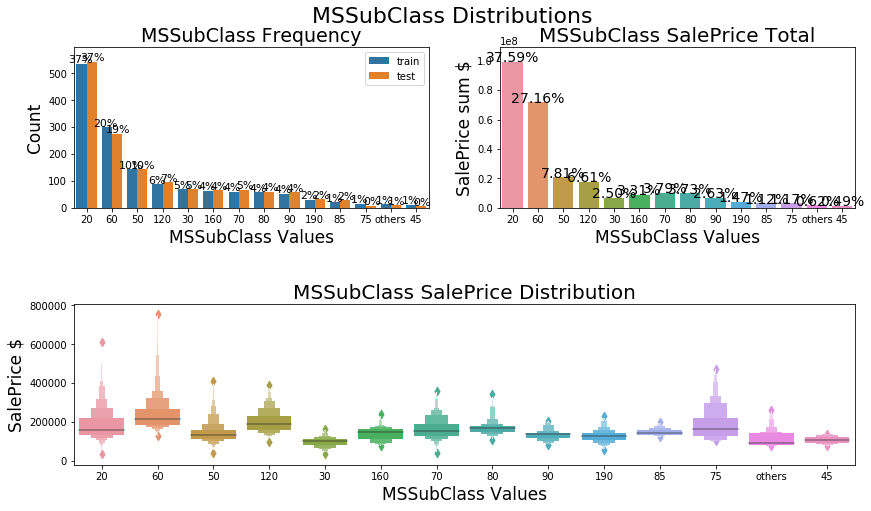

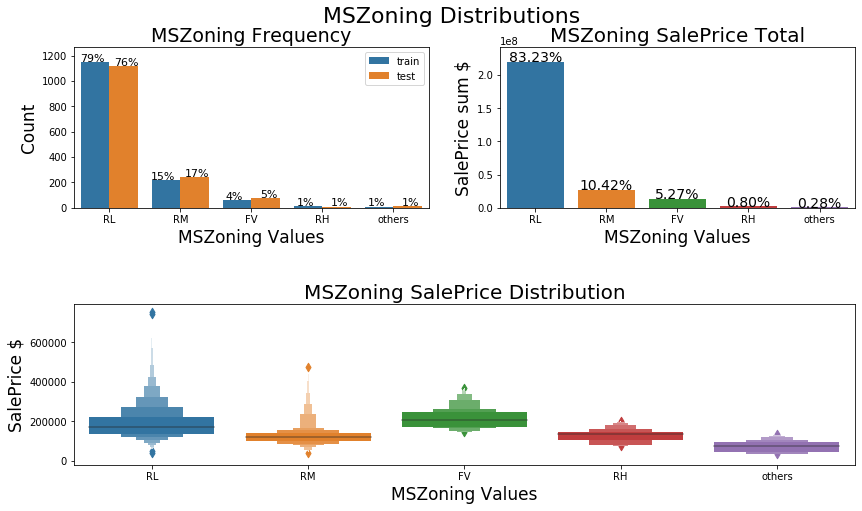

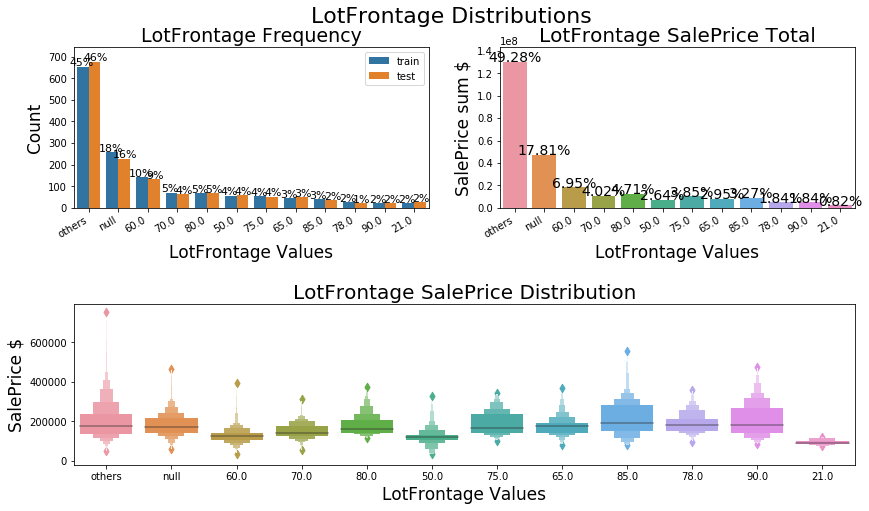

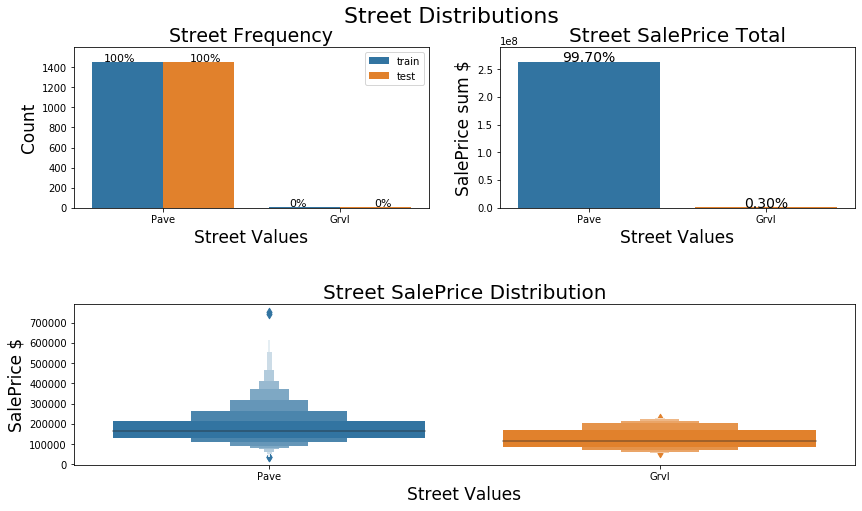

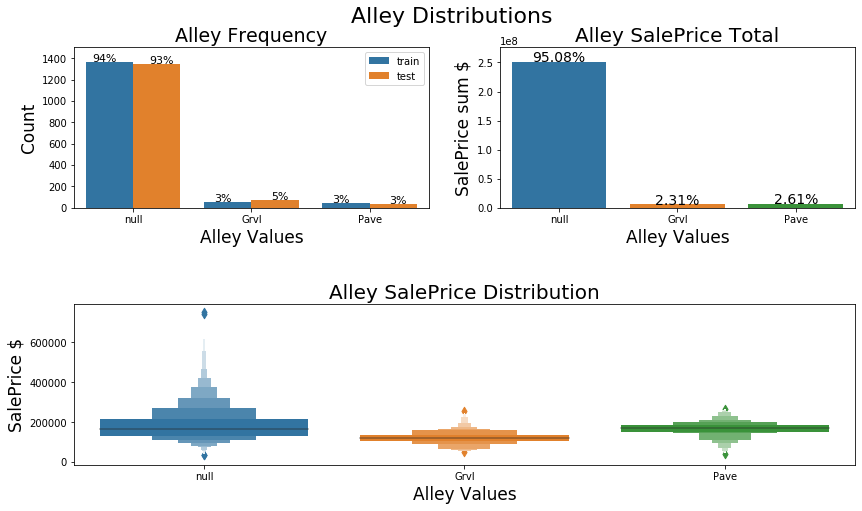

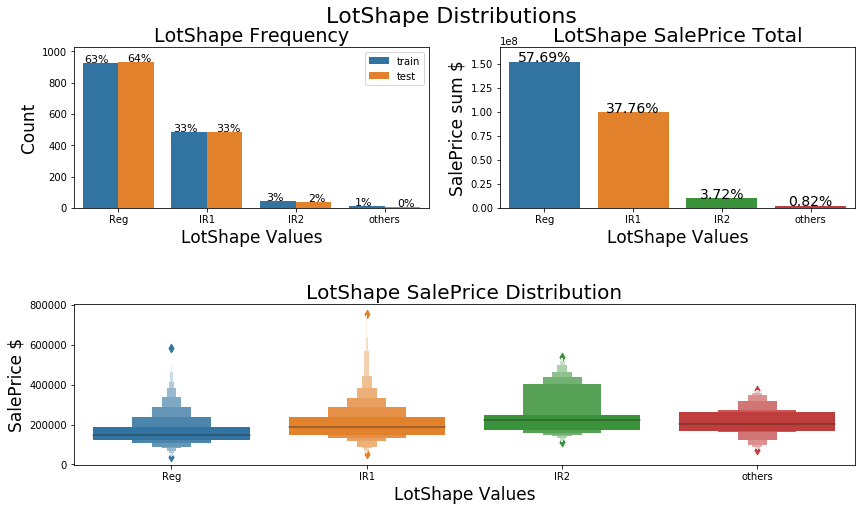

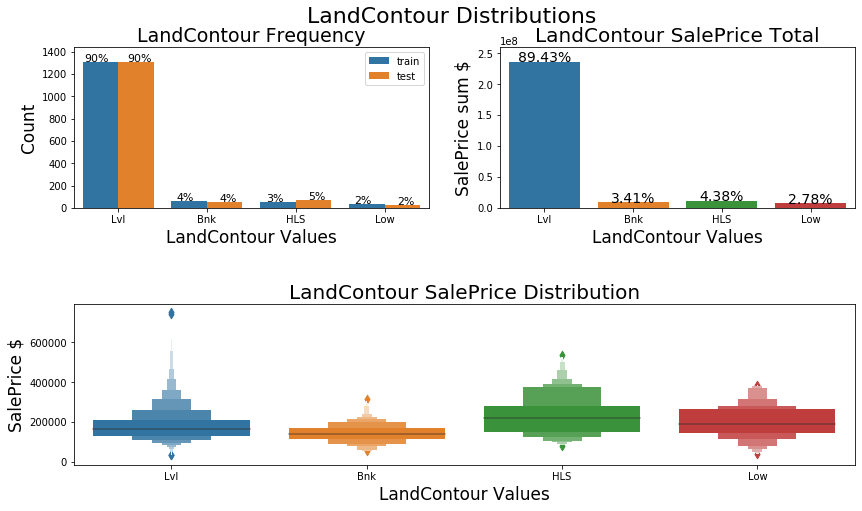

posx and posy should be finite values
posx and posy should be finite values


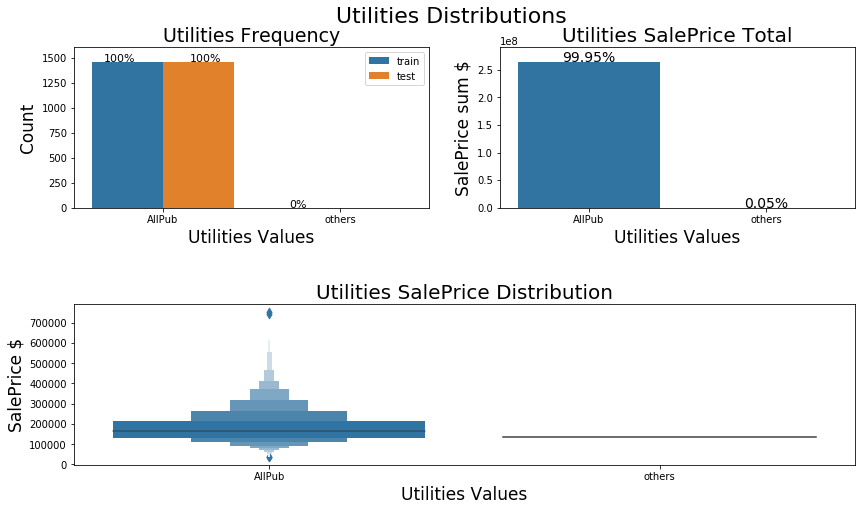

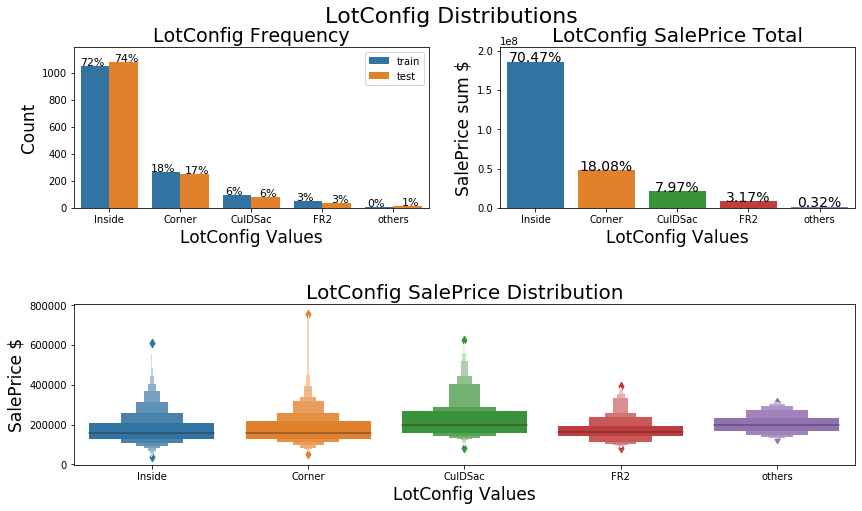

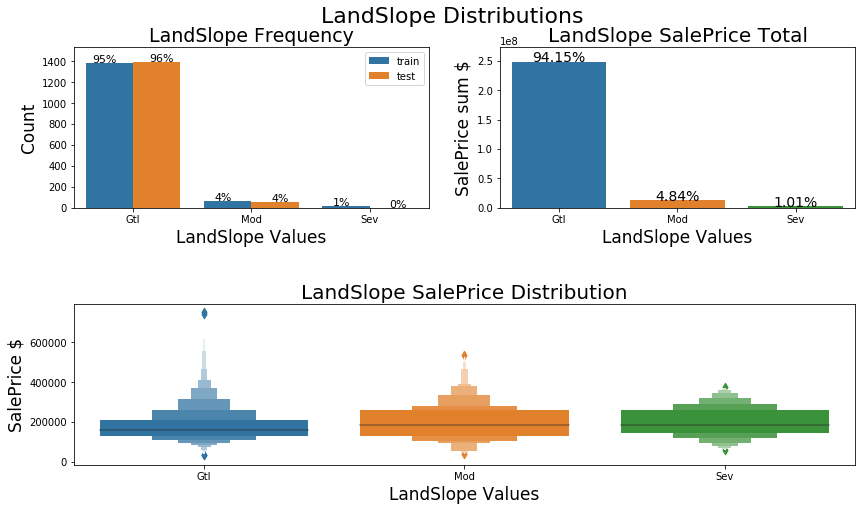

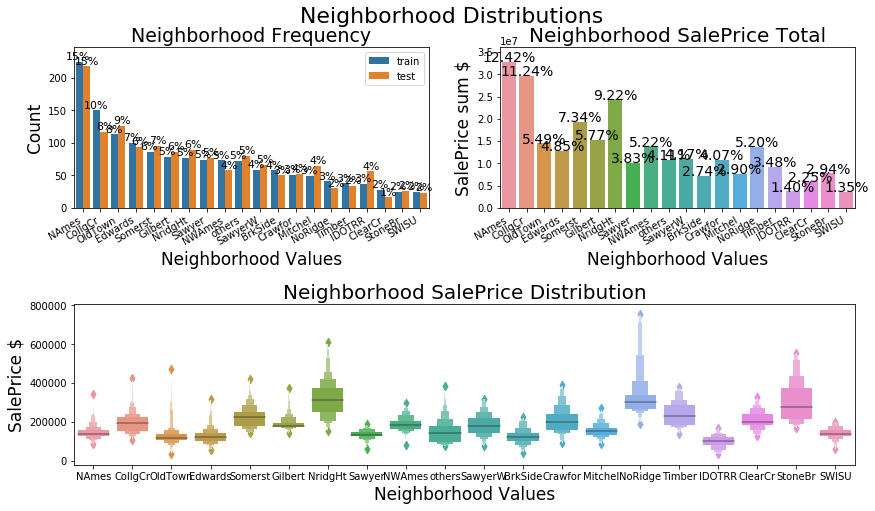

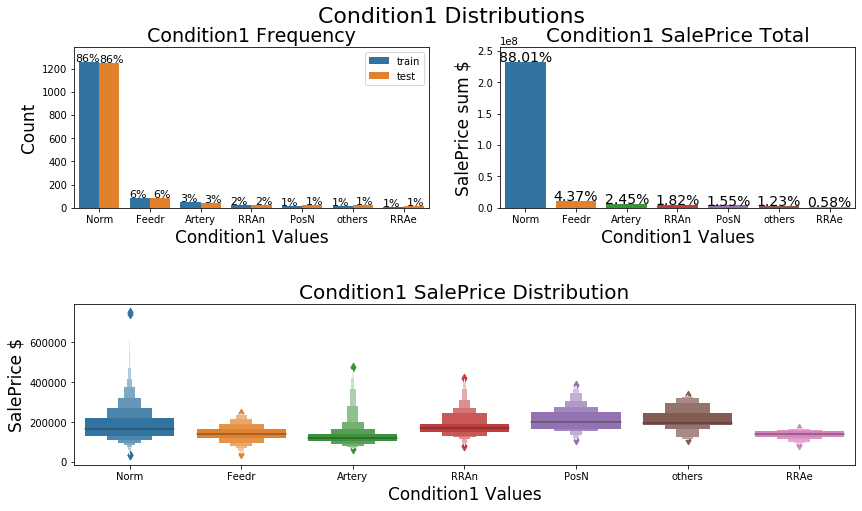

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


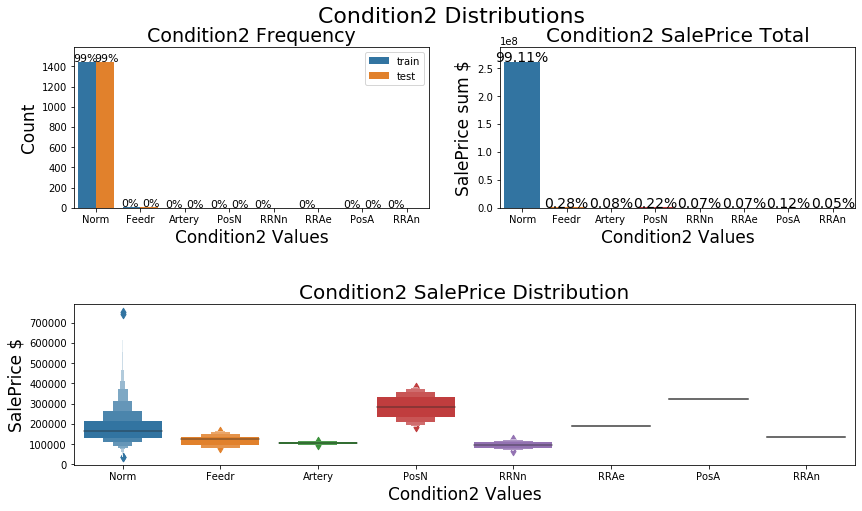

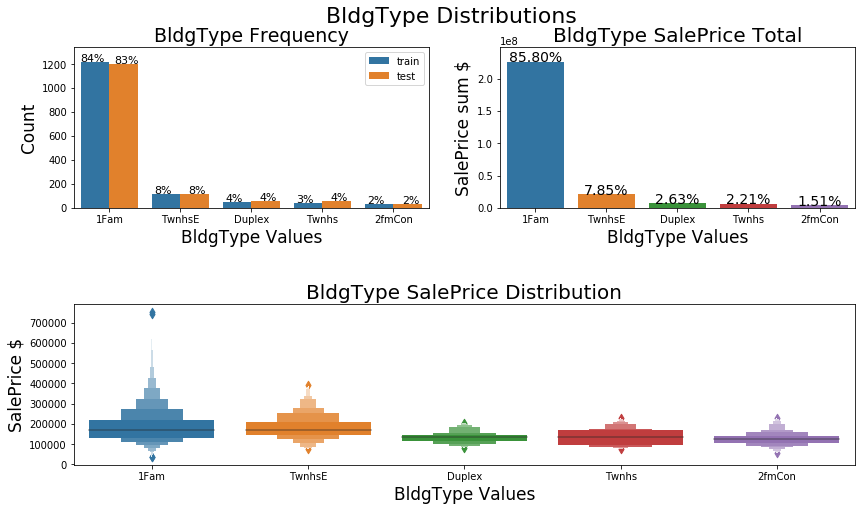

posx and posy should be finite values
posx and posy should be finite values


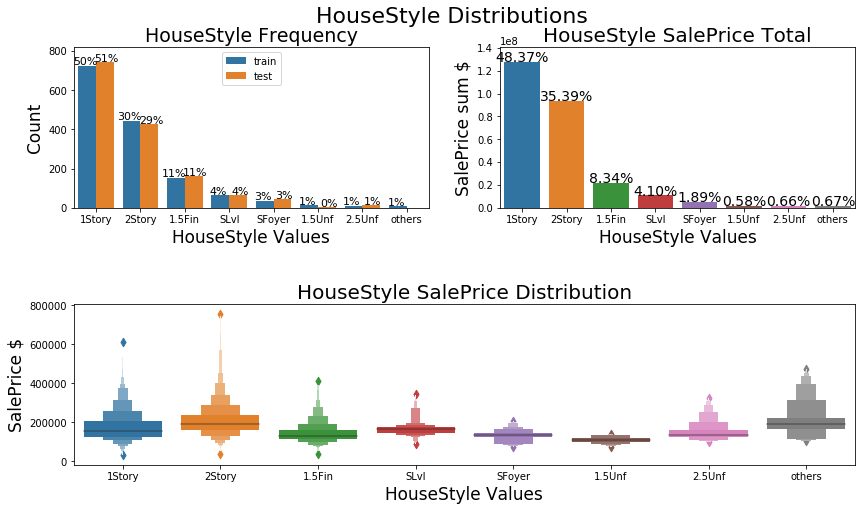

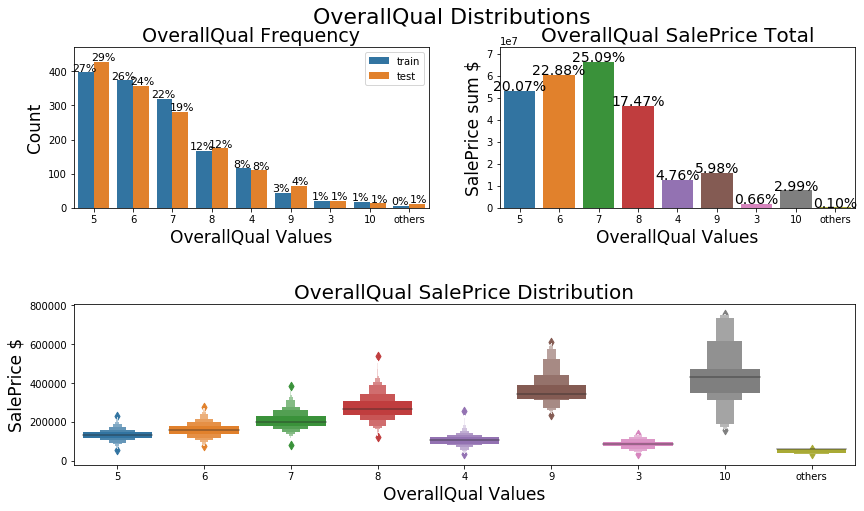

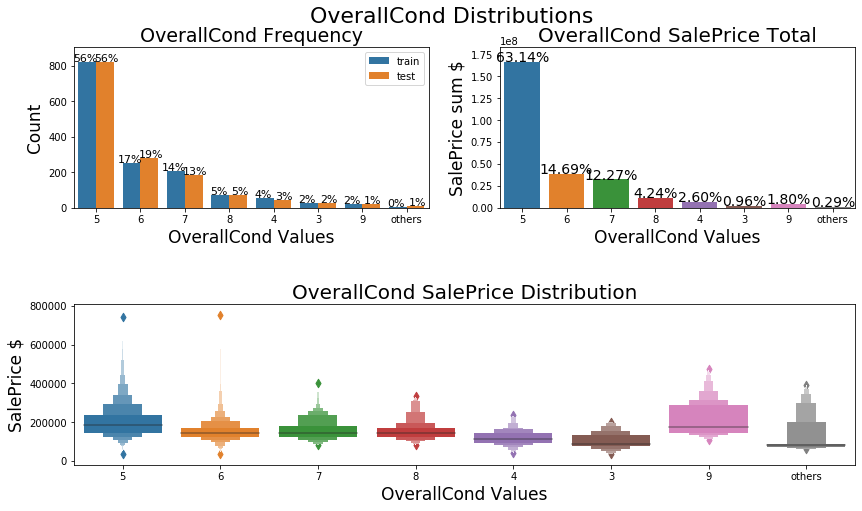

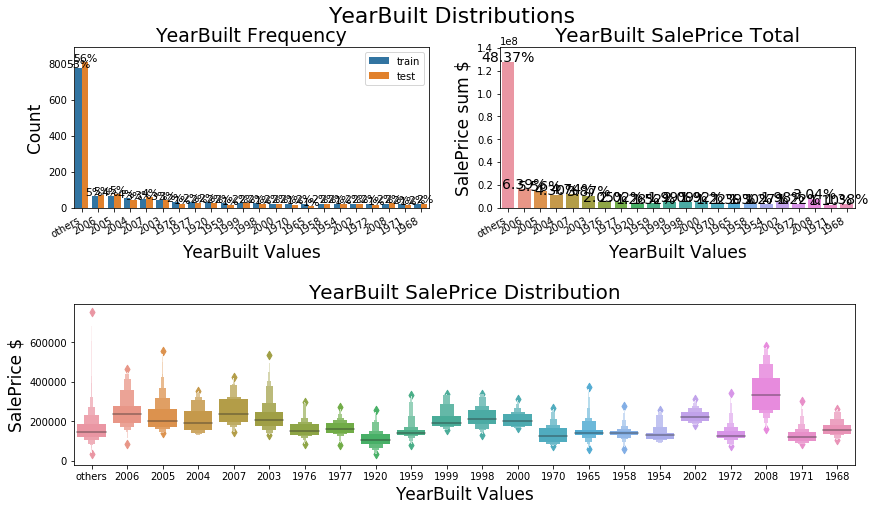

In [145]:
for feature in df.columns[:20]:
    if feature in ['Id','LotArea']:
        continue
    if feature in ['YearBuilt','LotFrontage','Neighborhood']:
        bar_plot(df,feature,others_threshold=20, xtick_rotate=True, df_test = test)
        continue
    if feature in ['Street','Condition2']:
        bar_plot(df,feature,others_threshold=0, df_test = test)
        continue
    bar_plot(df,feature, df_test = test)

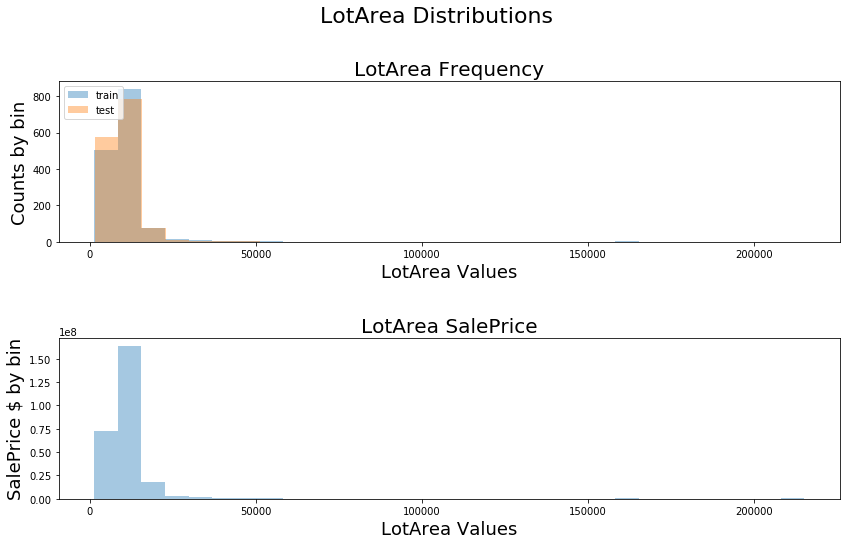

In [70]:
dist_plot(df,'LotArea' ,df_test = test)

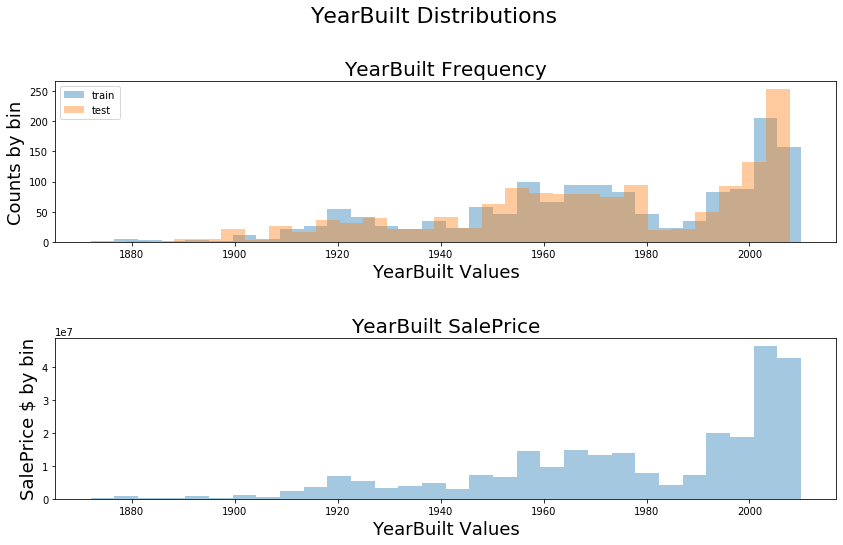

In [177]:
for feature in ['YearBuilt']:
    dist_plot(df,feature , df_test = test)

In [71]:
summary_table(df[list(df.columns)[20:40]])

dtypes  missing  uniques   min   max      top  1-freq 2nd most  \
YearRemodAdd    int64        0       61  1950  2010     1950     178     2006   
RoofStyle      object        0        6     -     -    Gable    1141      Hip   
RoofMatl       object        0        8     -     -  CompShg    1434  Tar&Grv   
Exterior1st    object        0       15     -     -  VinylSd     515  HdBoard   
Exterior2nd    object        0       16     -     -  VinylSd     504  MetalSd   
MasVnrType     object        8        4     -     -     None     864  BrkFace   
MasVnrArea    float64        8      327     0  1600        0     861       72   
ExterQual      object        0        4     -     -       TA     906       Gd   
ExterCond      object        0        5     -     -       TA    1282       Gd   
Foundation     object        0        6     -     -    PConc     647   CBlock   
BsmtQual       object       37        4     -     -       TA     649       Gd   
BsmtCond       object       37        4     -     -       TA    1311       Gd   
BsmtExposure   object       38        4     -     -       No     953       Av   
BsmtFinType1   object       37        6     -     -      Unf     430      GLQ   
BsmtFinSF1      int64        0      637     0  5644        0     467       24   
BsmtFinType2   object       38        6     -     -      Unf    1256      Rec   
BsmtFinSF2      int64        0      144     0  1474        0    1293      180   
BsmtUnfSF       int64        0      780     0  2336        0     118      728   
TotalBsmtSF     int64        0      721     0  6110        0      37      864   
Heating        object        0        6     -     -     GasA    1428     GasW   

              2-freq 3rd most  3-freq  
YearRemodAdd      97     2007      76  
RoofStyle        286     Flat      13  
RoofMatl          11  WdShngl       6  
Exterior1st      222  MetalSd     220  
Exterior2nd      214  HdBoard     207  
MasVnrType       445    Stone     128  
MasVnrArea         8      180       8  
ExterQual        488       Ex      52  
ExterCond        146       Fa      28  
Foundation       634   BrkTil     146  
BsmtQual         618       Ex     121  
BsmtCond          65       Fa      45  
BsmtExposure     221       Gd     134  
BsmtFinType1     418      ALQ     220  
BsmtFinSF1        12       16       9  
BsmtFinType2      54      LwQ      46  
BsmtFinSF2         5      374       3  
BsmtUnfSF          9      384       8  
TotalBsmtSF       35      672      17  
Heating           18     Grav       7

In [79]:
summary_table(test[list(test.columns)[20:40]])

dtypes  missing  uniques   min   max      top  1-freq 2nd most  \
YearRemodAdd    int64        0       61  1950  2010     1950     183     2006   
RoofStyle      object        0        6     -     -    Gable    1169      Hip   
RoofMatl       object        0        4     -     -  CompShg    1442  Tar&Grv   
Exterior1st    object        1       13     -     -  VinylSd     510  MetalSd   
Exterior2nd    object        1       15     -     -  VinylSd     510  MetalSd   
MasVnrType     object       16        4     -     -     None     878  BrkFace   
MasVnrArea    float64       15      303     0  1290        0     877      176   
ExterQual      object        0        4     -     -       TA     892       Gd   
ExterCond      object        0        5     -     -       TA    1256       Gd   
Foundation     object        0        6     -     -    PConc     661   CBlock   
BsmtQual       object       44        4     -     -       TA     634       Gd   
BsmtCond       object       45        4     -     -       TA    1295       Fa   
BsmtExposure   object       44        4     -     -       No     951       Av   
BsmtFinType1   object       42        6     -     -      GLQ     431      Unf   
BsmtFinSF1    float64        1      669     0  4010        0     462       24   
BsmtFinType2   object       42        6     -     -      Unf    1237      Rec   
BsmtFinSF2    float64        1      161     0  1526        0    1278      162   
BsmtUnfSF     float64        1      793     0  2140        0     123      384   
TotalBsmtSF   float64        1      736     0  5095        0      41      864   
Heating        object        0        4     -     -     GasA    1446     GasW   

              2-freq 3rd most  3-freq  
YearRemodAdd     105     2007      88  
RoofStyle        265  Gambrel      11  
RoofMatl          12  WdShake       4  
Exterior1st      230  HdBoard     220  
Exterior2nd      233  HdBoard     199  
MasVnrType       434    Stone     121  
MasVnrArea        10      144       9  
ExterQual        491       Ex      55  
ExterCond        153       Fa      39  
Foundation       601   BrkTil     165  
BsmtQual         591       Ex     137  
BsmtCond          59       Gd      57  
BsmtExposure     197       Gd     142  
BsmtFinType1     421      ALQ     209  
BsmtFinSF1        15      276       6  
BsmtFinType2      51      LwQ      41  
BsmtFinSF2         3      294       3  
BsmtUnfSF         11      624       8  
TotalBsmtSF       39      960      13  
Heating            9     Wall       2

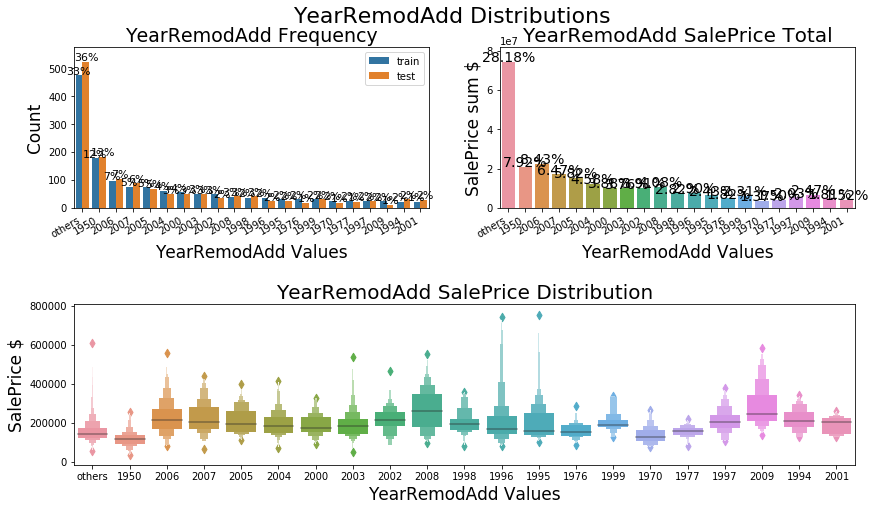

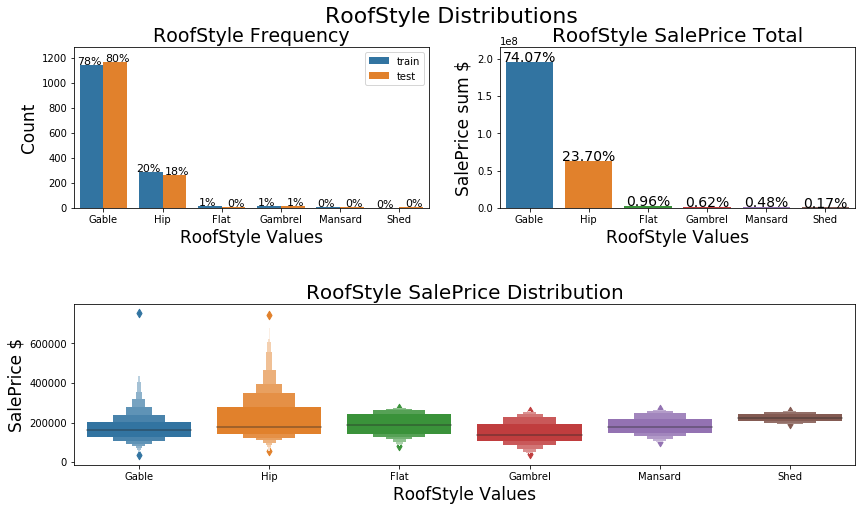

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


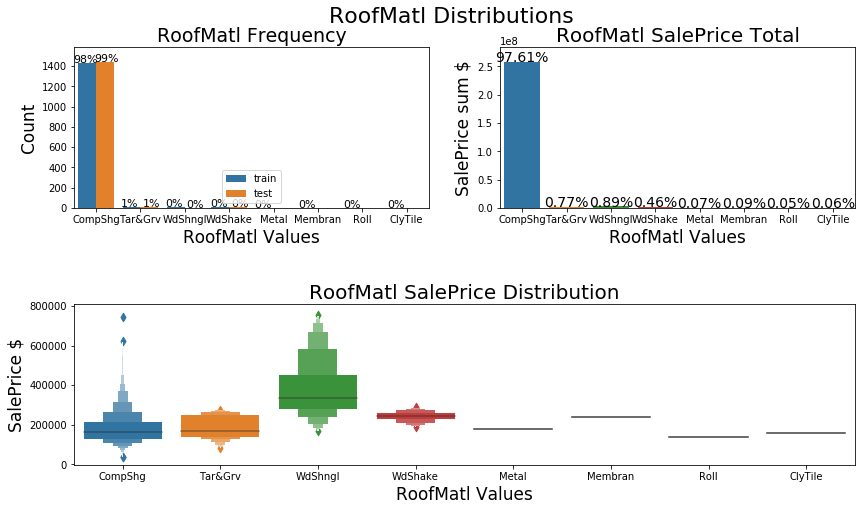

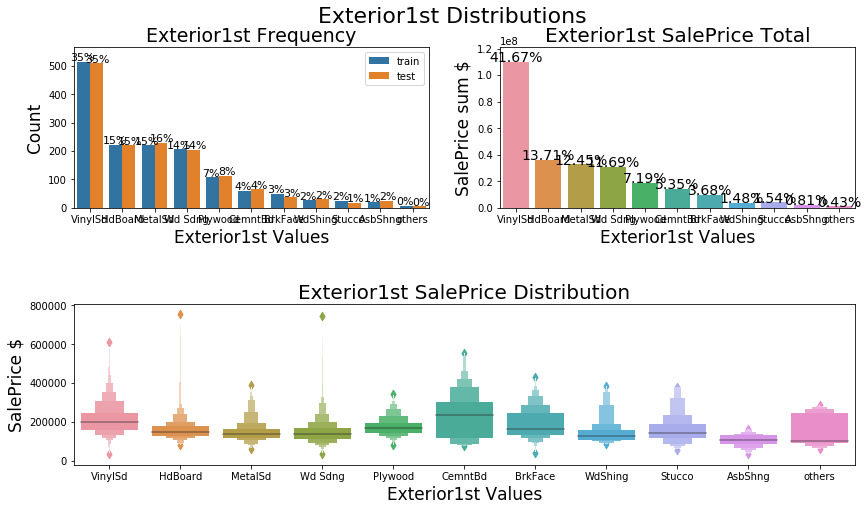

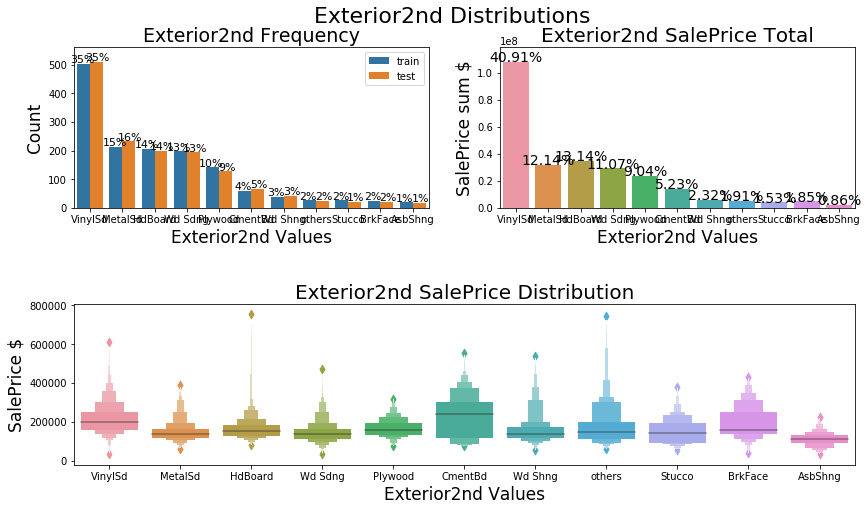

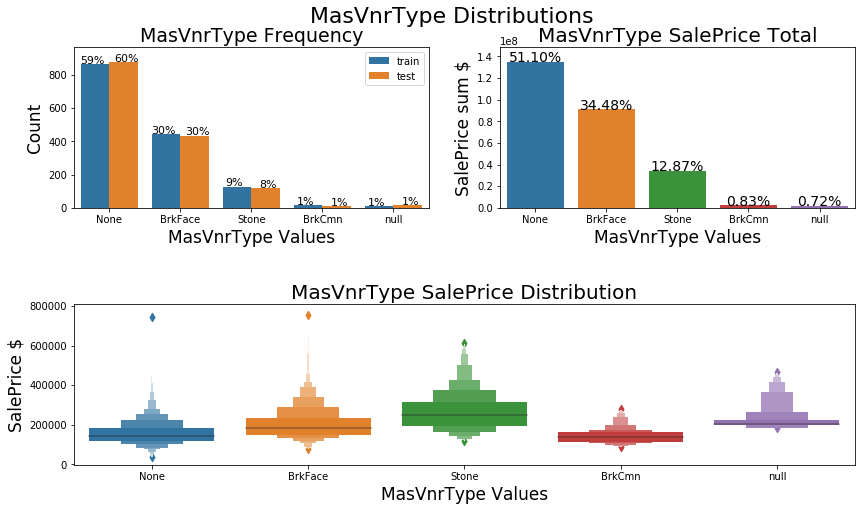

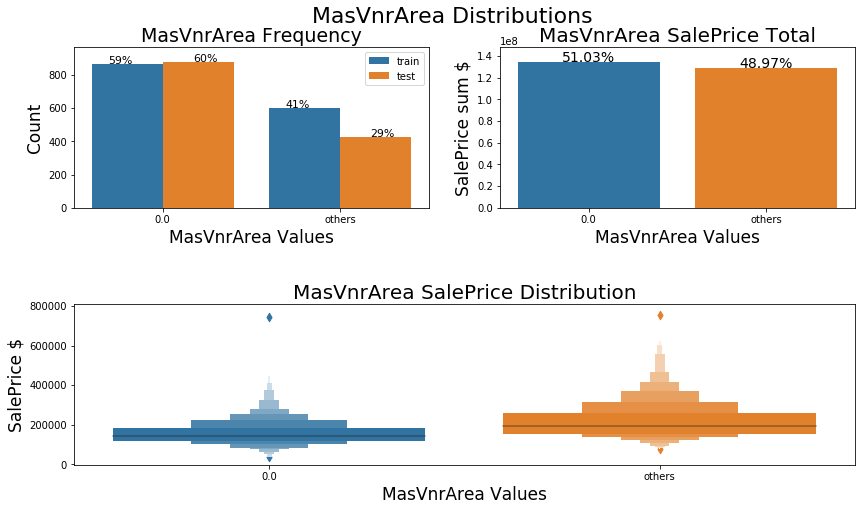

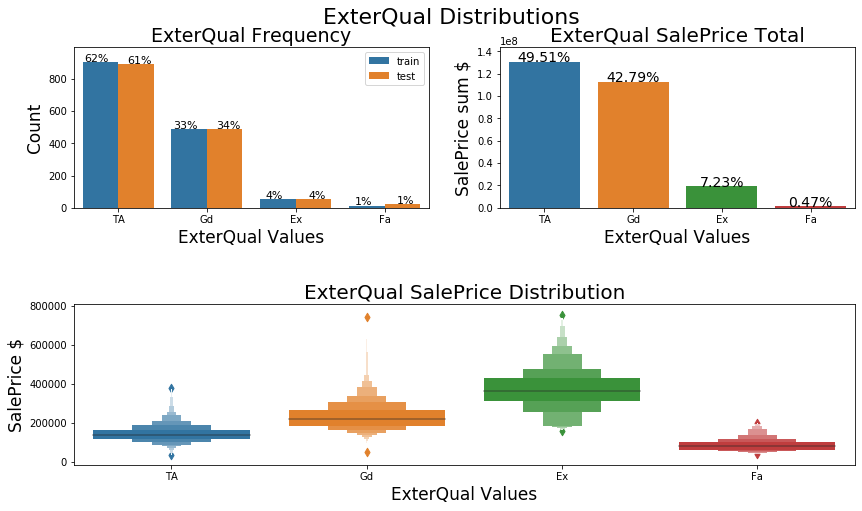

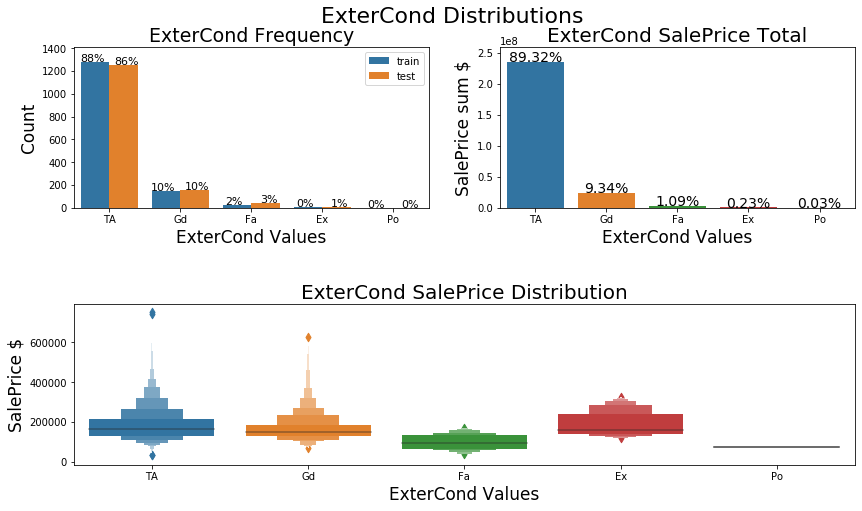

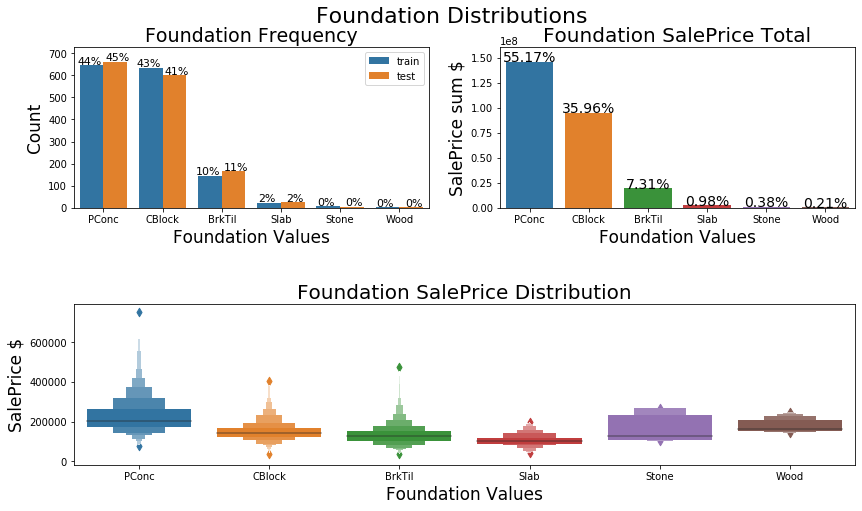

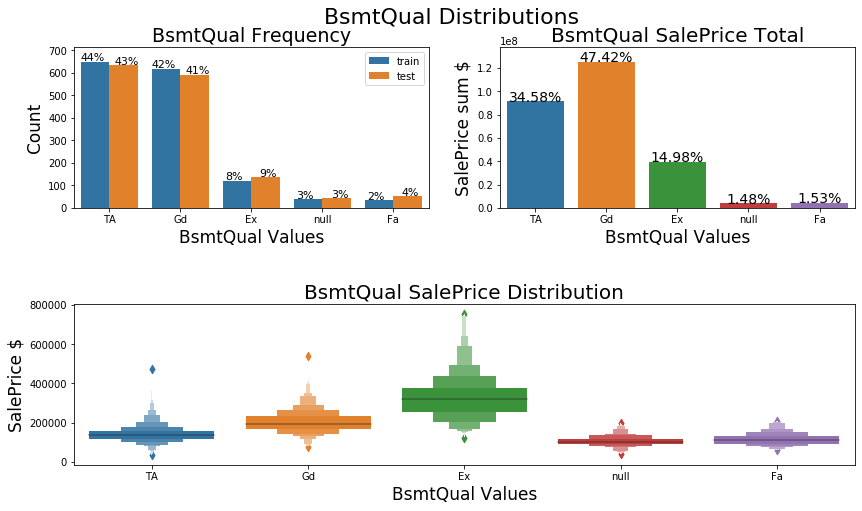

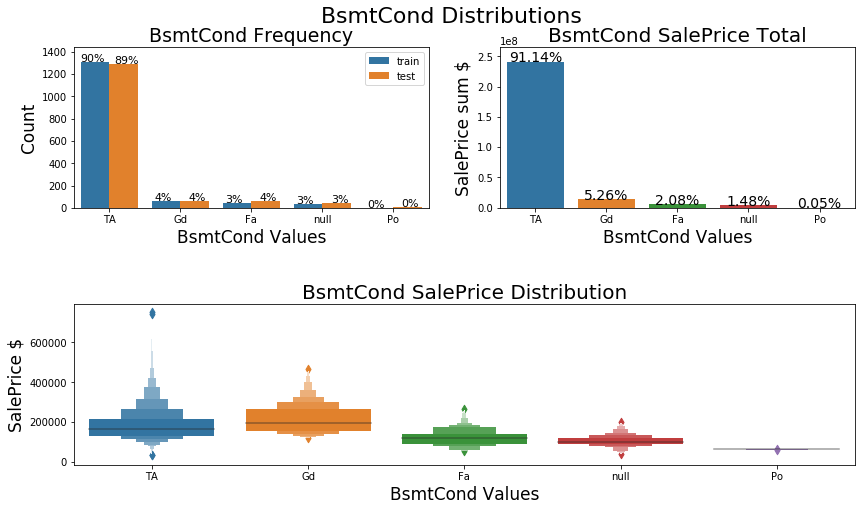

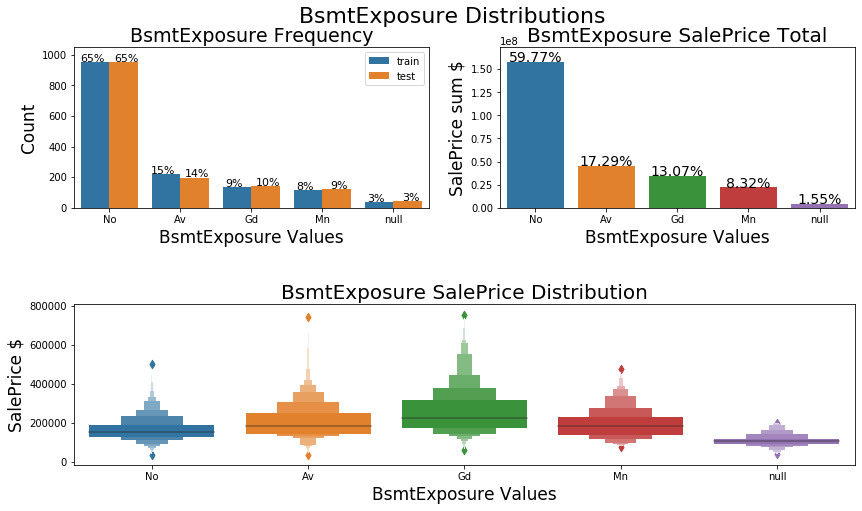

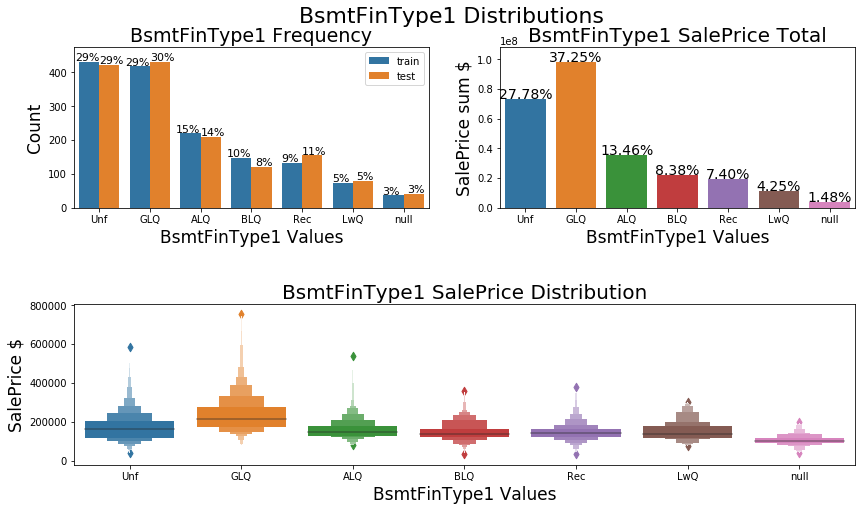

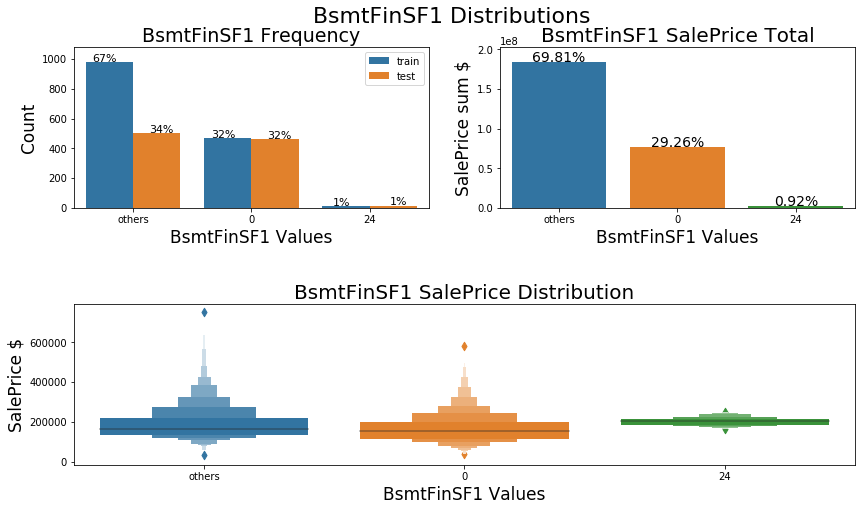

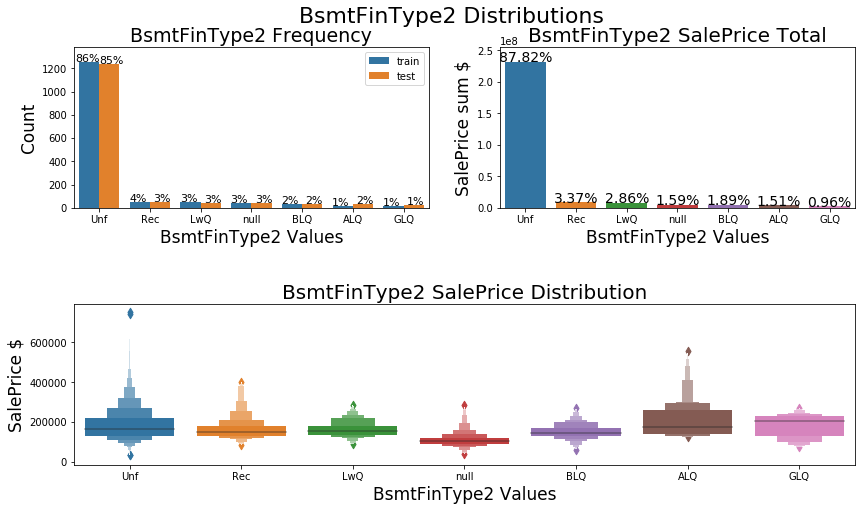

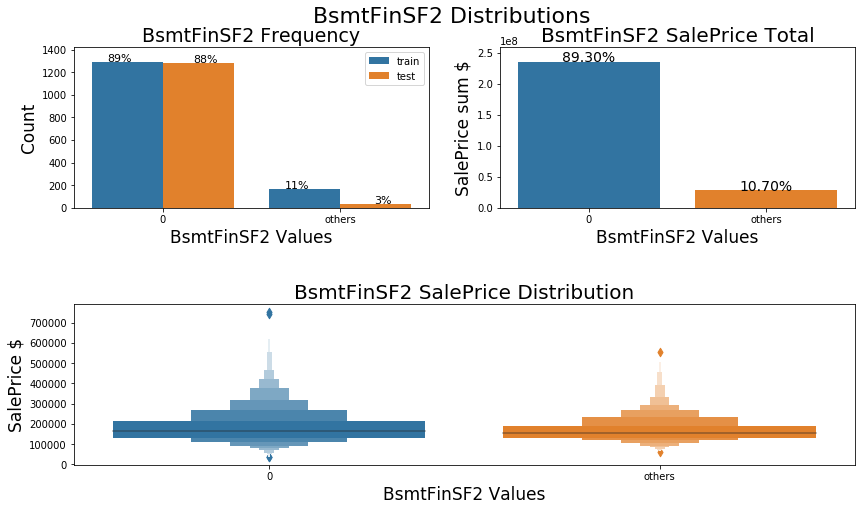

posx and posy should be finite values
posx and posy should be finite values


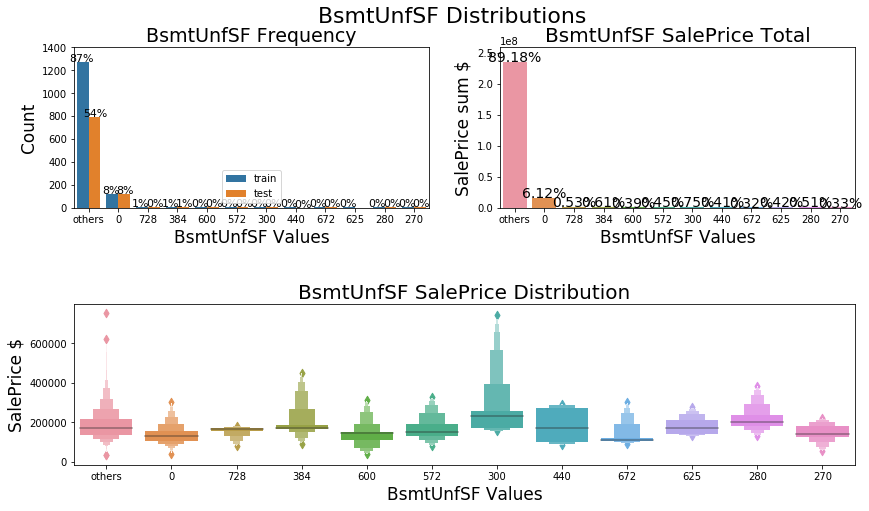

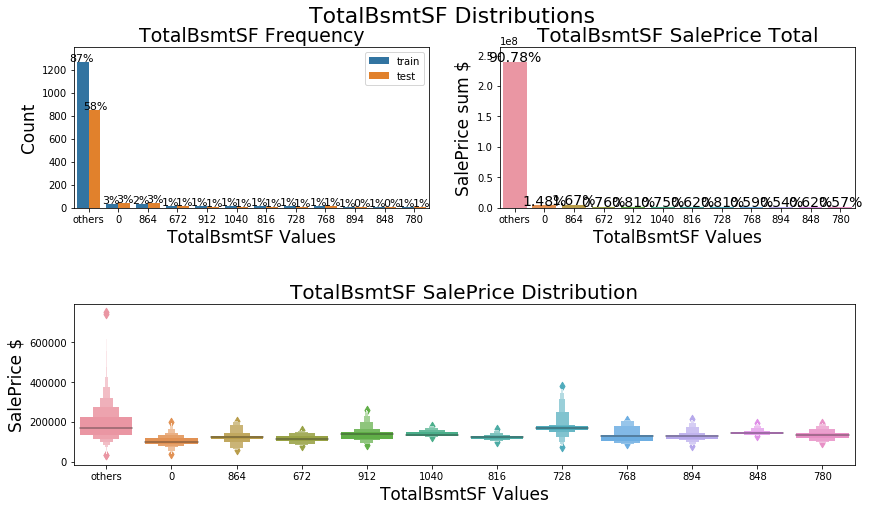

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


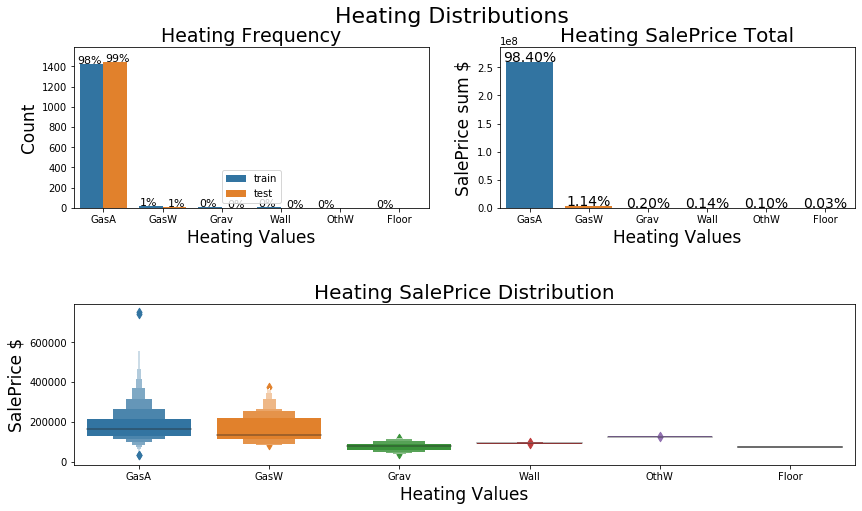

In [148]:
for feature in df.columns[20:40]:
    if df[feature].nunique() < 10:
        bar_plot(df,feature,others_threshold=0, df_test =test)
        continue
    if feature in ['YearRemodAdd']:
        bar_plot(df,feature,others_threshold=20, xtick_rotate=True, df_test = test)
        continue
    if feature in ['BsmtFinSF2','BsmtUnfSF']:
        bar_plot(df,feature,others_threshold=5,  df_test = test)
        continue  
    bar_plot(df,feature, df_test = test)

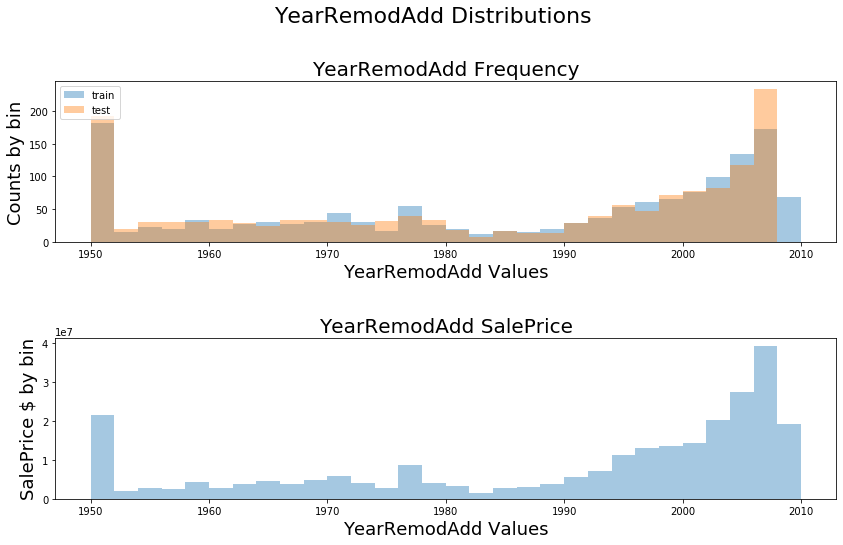

In [157]:
for feature in ['YearRemodAdd']:
    dist_plot(df,feature ,df_test = test)

In [72]:
summary_table(df[list(df.columns)[40:60]])

dtypes  missing  uniques   min   max     top 1-freq 2nd most  \
HeatingQC      object        0        5     -     -      Ex    741       TA   
CentralAir     object        0        2     -     -       Y   1365        N   
Electrical     object        1        5     -     -   SBrkr   1334    FuseA   
1stFlrSF        int64        0      753   334  4692     864     25     1040   
2ndFlrSF        int64        0      417     0  2065       0    829      728   
LowQualFinSF    int64        0       24     0   572       0   1434       80   
GrLivArea       int64        0      861   334  5642     864     22     1040   
BsmtFullBath    int64        0        4     0     3       0    856        1   
BsmtHalfBath    int64        0        3     0     2       0   1378        1   
FullBath        int64        0        4     0     3       2    768        1   
HalfBath        int64        0        3     0     2       0    913        1   
BedroomAbvGr    int64        0        8     0     8       3    804        2   
KitchenAbvGr    int64        0        4     0     3       1   1392        2   
KitchenQual    object        0        4     -     -      TA    735       Gd   
TotRmsAbvGrd    int64        0       12     2    14       6    402        7   
Functional     object        0        7     -     -     Typ   1360     Min2   
Fireplaces      int64        0        4     0     3       0    690        1   
FireplaceQu    object      690        5     -     -      Gd    380       TA   
GarageType     object       81        6     -     -  Attchd    870   Detchd   
GarageYrBlt   float64       81       97  1900  2010    2005     65     2006   

             2-freq 3rd most 3-freq  
HeatingQC       428       Gd    241  
CentralAir       95        -      -  
Electrical       94    FuseF     27  
1stFlrSF         16      912     14  
2ndFlrSF         10      504      9  
LowQualFinSF      3      360      2  
GrLivArea        14      894     11  
BsmtFullBath    588        2     15  
BsmtHalfBath     80        2      2  
FullBath        650        3     33  
HalfBath        535        2     12  
BedroomAbvGr    358        4    213  
KitchenAbvGr     65        3      2  
KitchenQual     586       Ex    100  
TotRmsAbvGrd    329        5    275  
Functional       34     Min1     31  
Fireplaces      650        2    115  
FireplaceQu     313       Fa     33  
GarageType      387  BuiltIn     88  
GarageYrBlt      59     2004     53

In [158]:
summary_table(test[list(test.columns)[40:60]])

dtypes  missing  uniques   min   max     top 1-freq 2nd most  \
HeatingQC      object        0        5     -     -      Ex    752       TA   
CentralAir     object        0        2     -     -       Y   1358        N   
Electrical     object        0        4     -     -   SBrkr   1337    FuseA   
1stFlrSF        int64        0      789   407  5095     864     21      546   
2ndFlrSF        int64        0      407     0  1862       0    839      546   
LowQualFinSF    int64        0       15     0  1064       0   1445     1064   
GrLivArea       int64        0      879   407  5095     864     19     1092   
BsmtFullBath  float64        2        4     0     3       0    849        1   
BsmtHalfBath  float64        2        3     0     2       0   1364        1   
FullBath        int64        0        5     0     4       2    762        1   
HalfBath        int64        0        3     0     2       0    921        1   
BedroomAbvGr    int64        0        7     0     6       3    792        2   
KitchenAbvGr    int64        0        3     0     2       1   1393        2   
KitchenQual    object        1        4     -     -      TA    757       Gd   
TotRmsAbvGrd    int64        0       12     3    15       6    442        7   
Functional     object        2        7     -     -     Typ   1357     Min2   
Fireplaces      int64        0        5     0     4       0    730        1   
FireplaceQu    object      730        5     -     -      Gd    364       TA   
GarageType     object       76        6     -     -  Attchd    853   Detchd   
GarageYrBlt   float64       78       97  1895  2207    2005     77     2007   

             2-freq 3rd most 3-freq  
HeatingQC       429       Gd    233  
CentralAir      101        -      -  
Electrical       94    FuseF     23  
1stFlrSF         12     1040     12  
2ndFlrSF         15      728      8  
LowQualFinSF      1      697      1  
GrLivArea        18     1040     11  
BsmtFullBath    584        2     23  
BsmtHalfBath     91        2      2  
FullBath        659        3     31  
HalfBath        525        2     13  
BedroomAbvGr    384        4    187  
KitchenAbvGr     64        0      2  
KitchenQual     565       Ex    105  
TotRmsAbvGrd    320        5    308  
Functional       36     Min1     34  
Fireplaces      618        2    104  
FireplaceQu     279       Fa     41  
GarageType      392  BuiltIn     98  
GarageYrBlt      66     2006     56

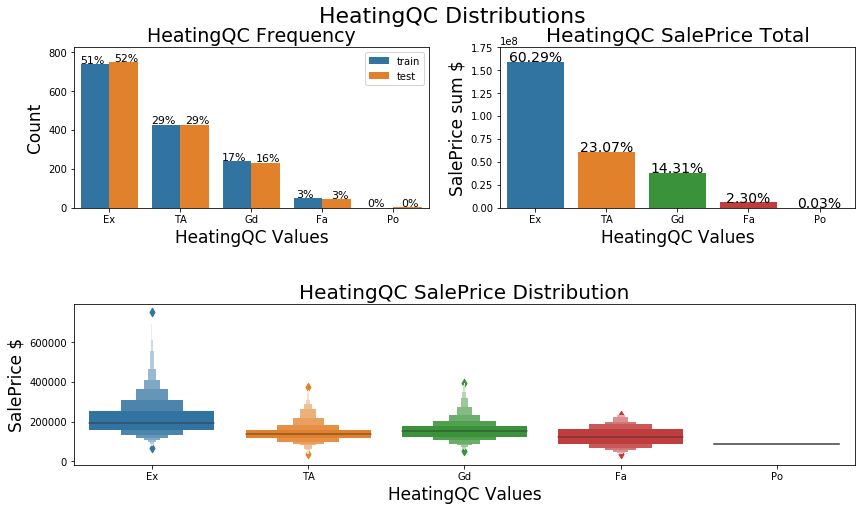

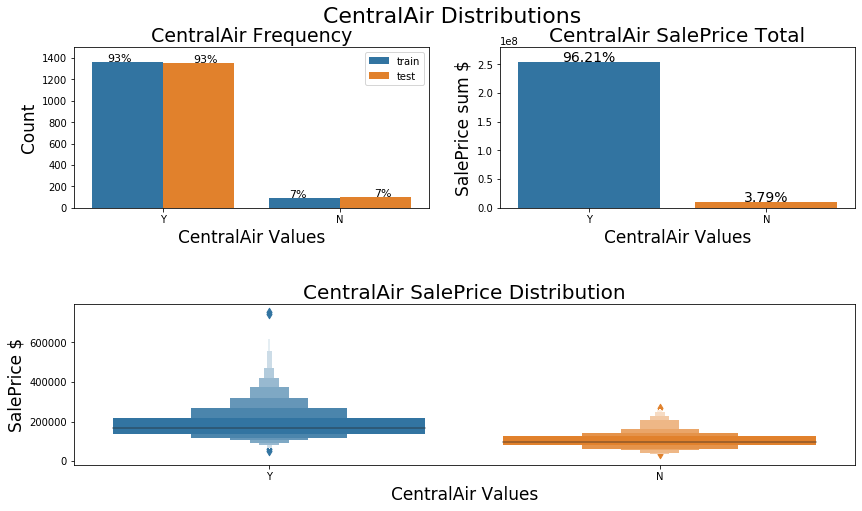

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


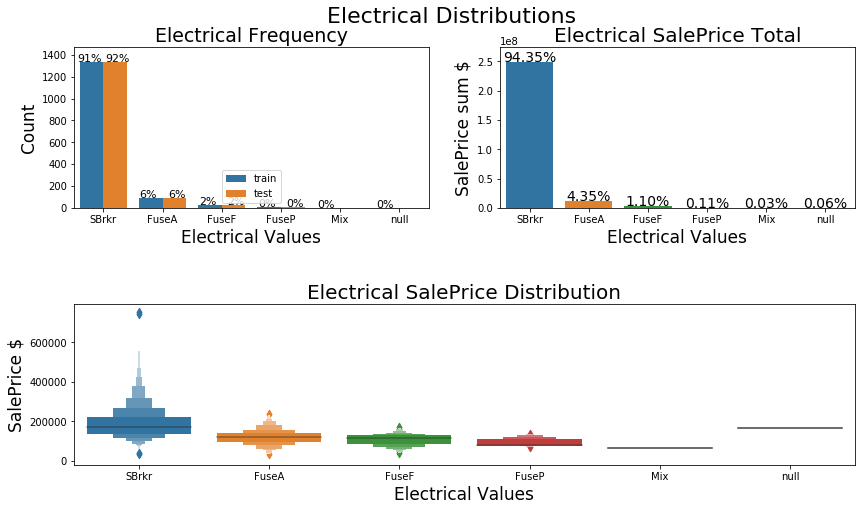

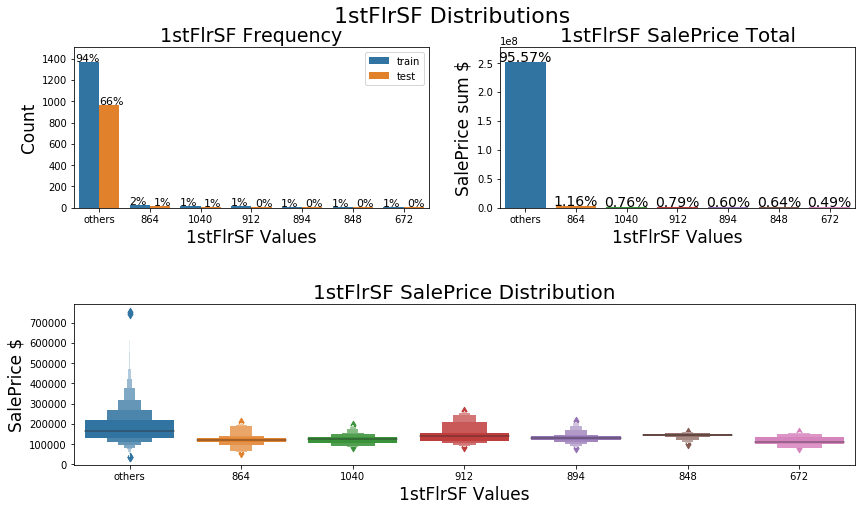

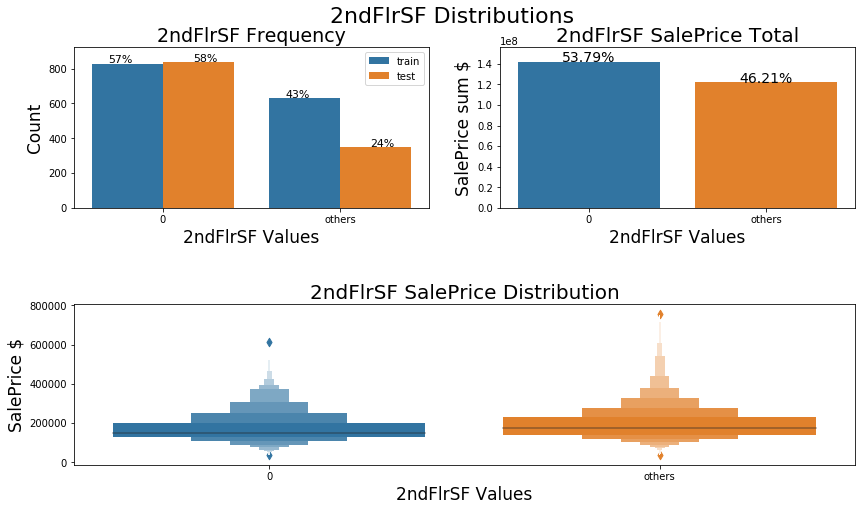

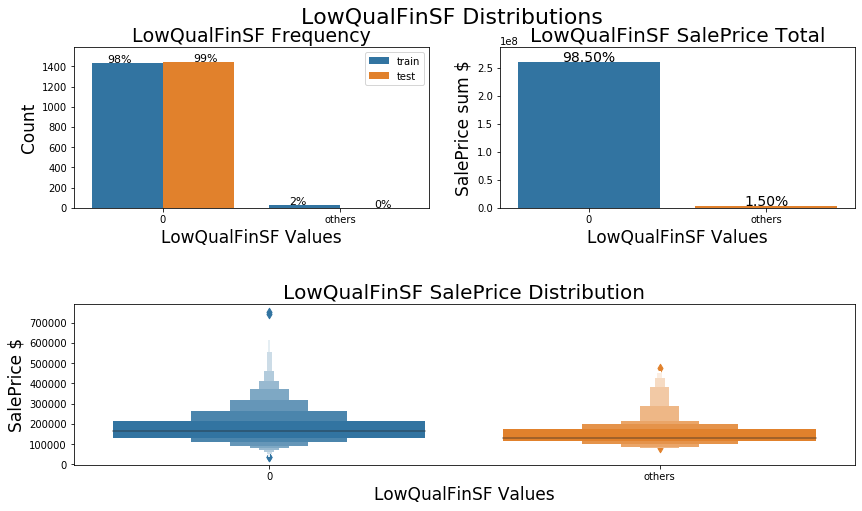

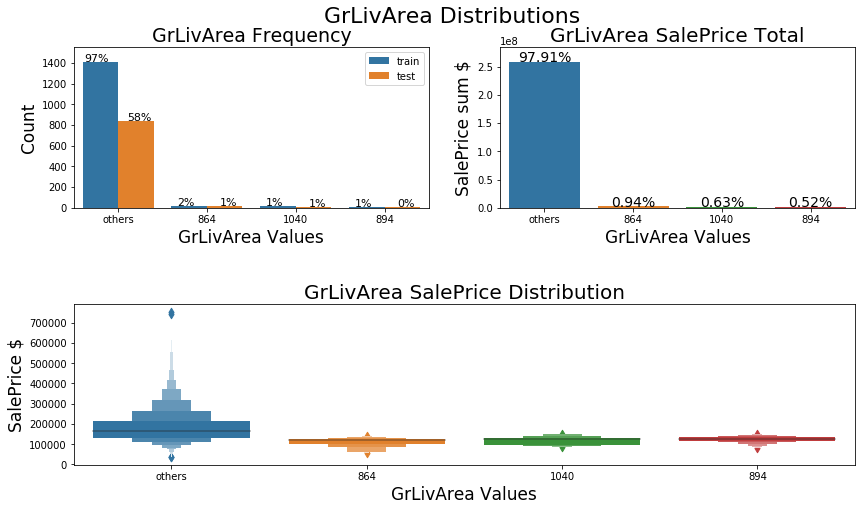

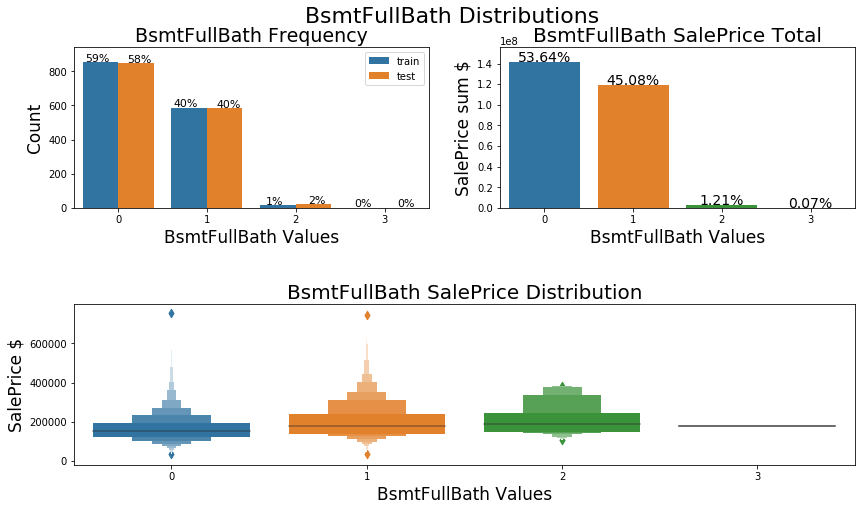

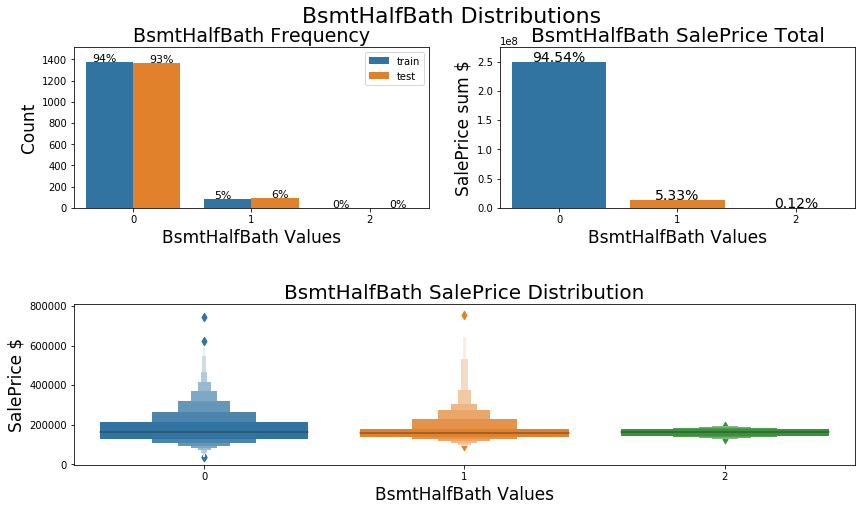

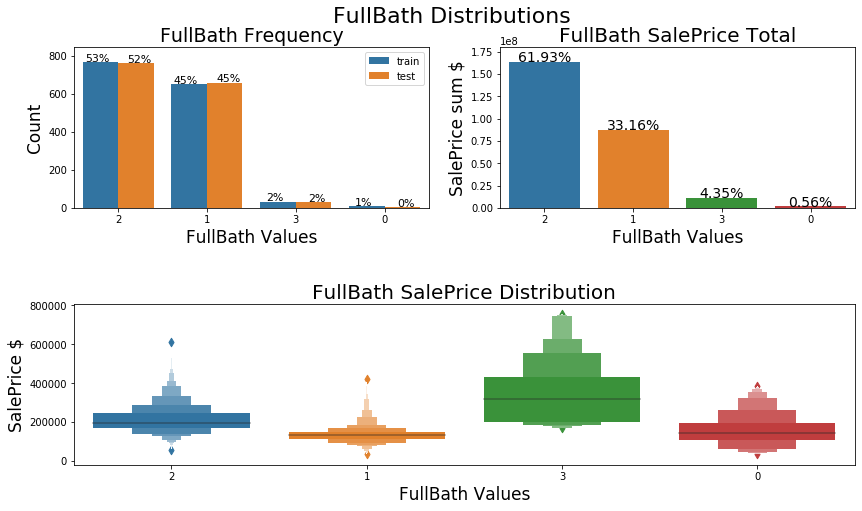

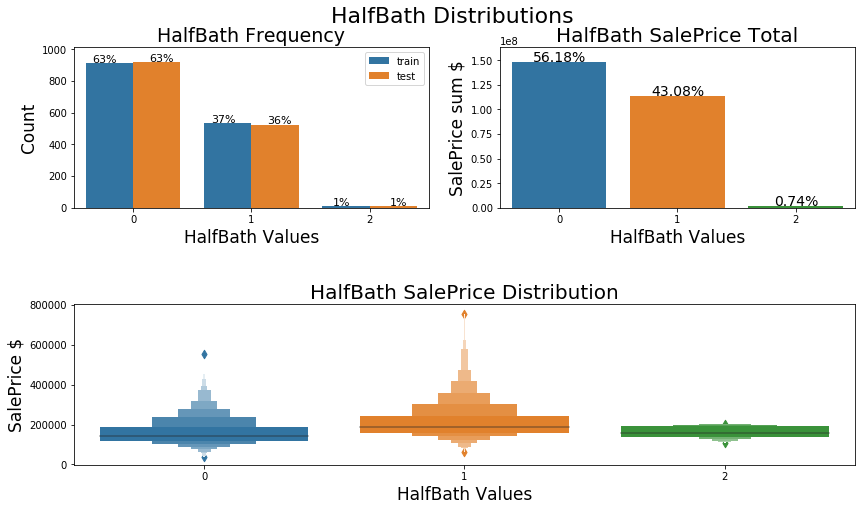

posx and posy should be finite values
posx and posy should be finite values


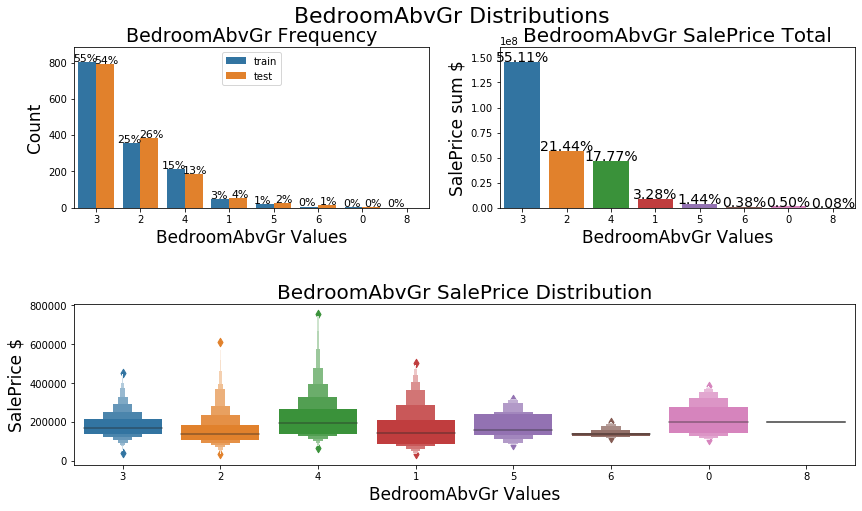

posx and posy should be finite values
posx and posy should be finite values


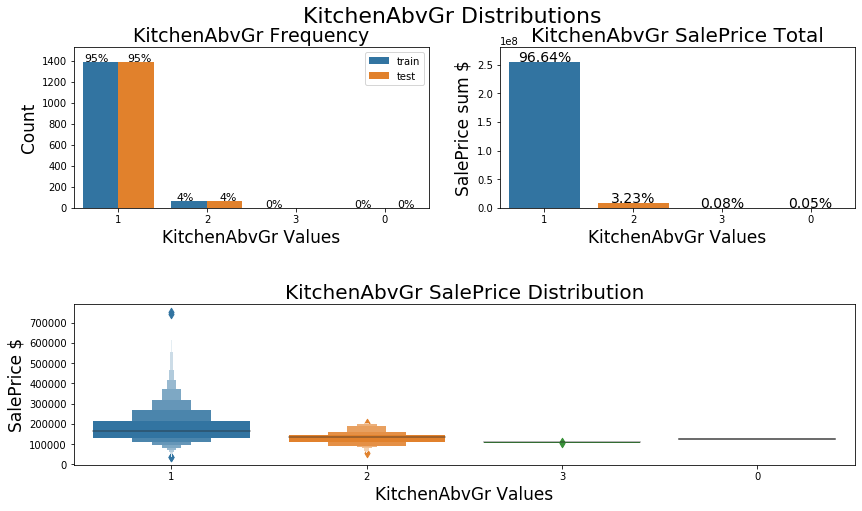

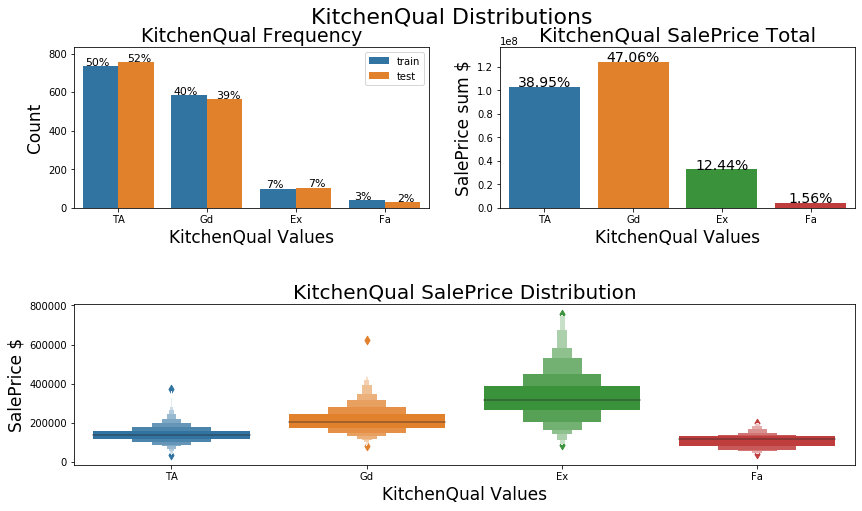

posx and posy should be finite values
posx and posy should be finite values


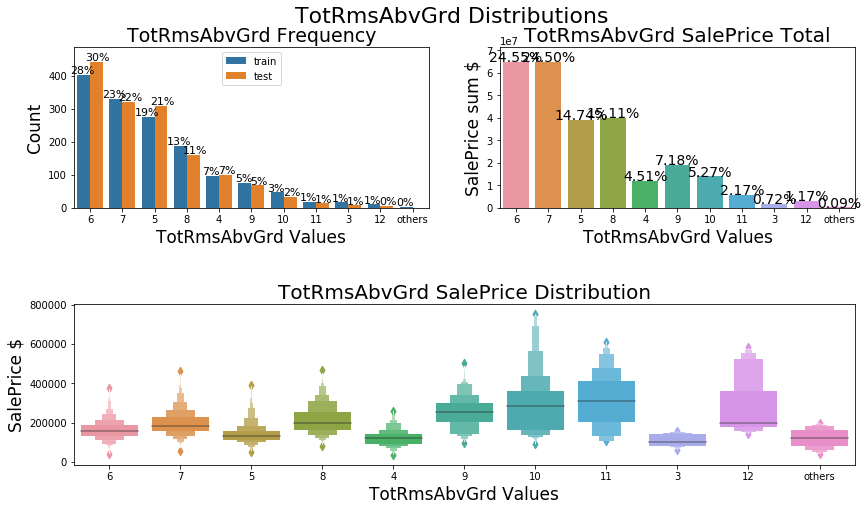

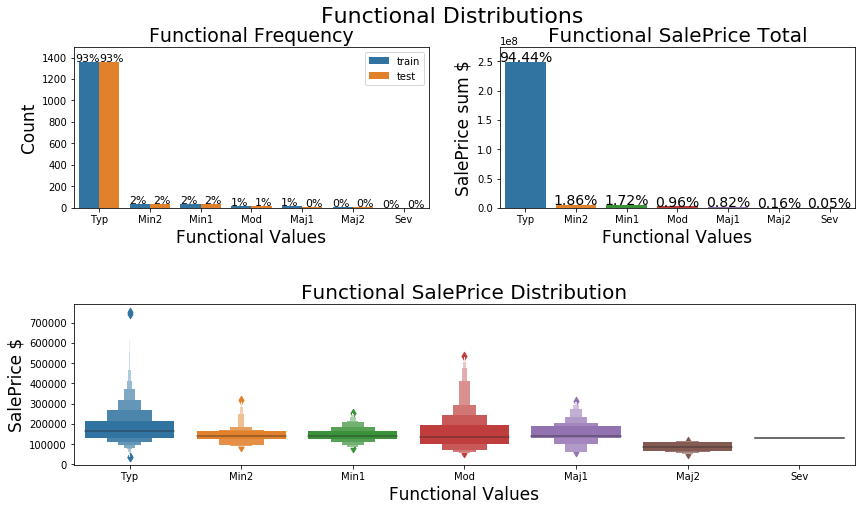

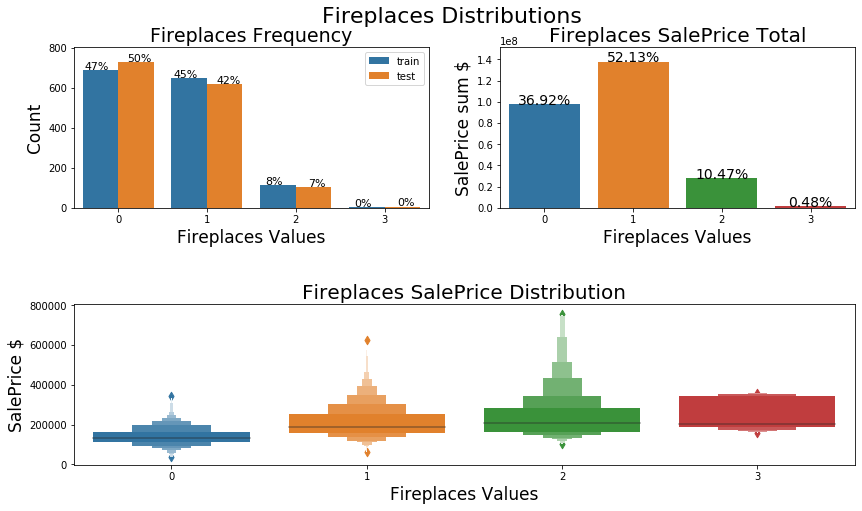

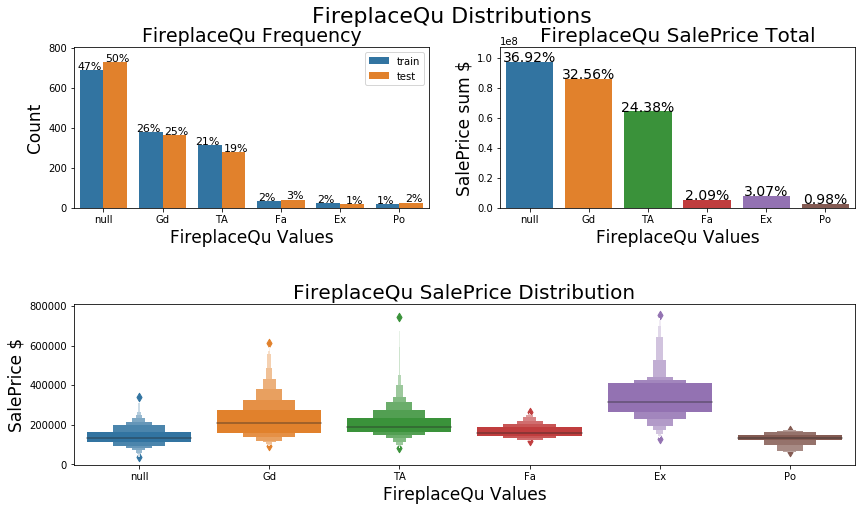

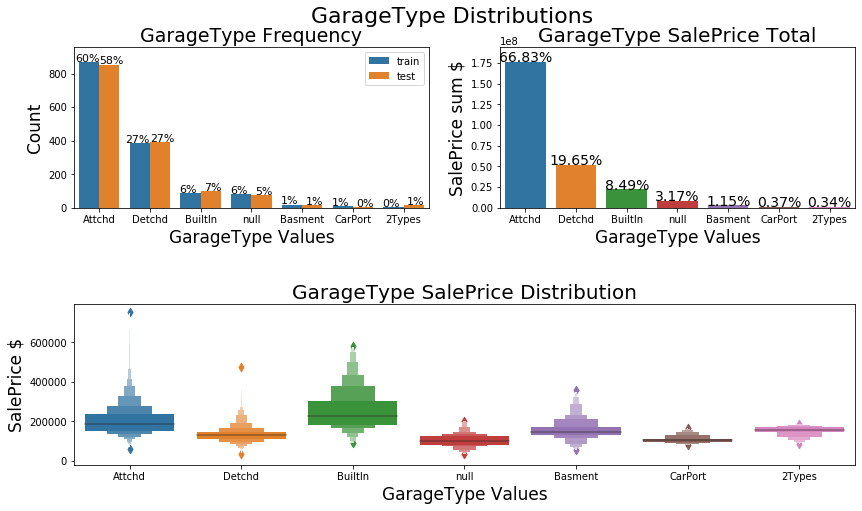

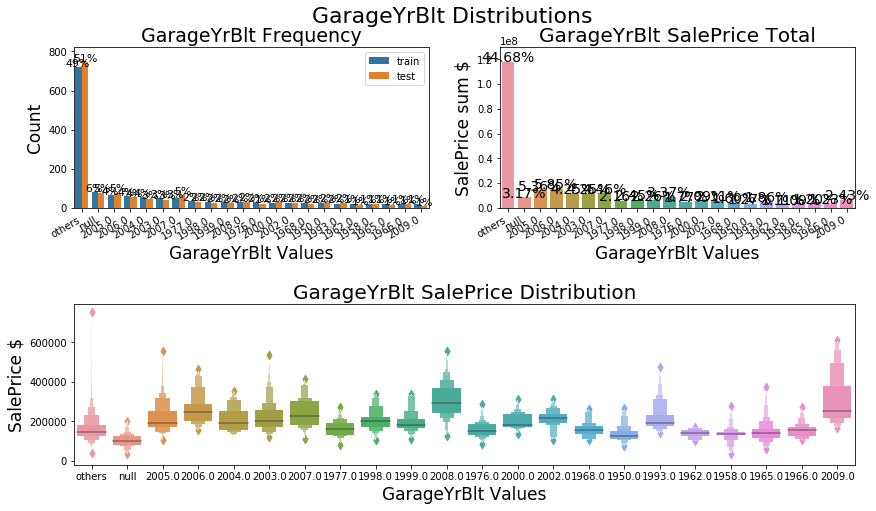

In [160]:
for feature in df.columns[40:60]:
    if df[feature].nunique() < 10:
        bar_plot(df,feature,others_threshold=0, df_test =test)
        continue
    if feature in ['GarageYrBlt']:
        bar_plot(df,feature,others_threshold=20, xtick_rotate=True, df_test = test)
        continue
    bar_plot(df,feature, df_test = test)

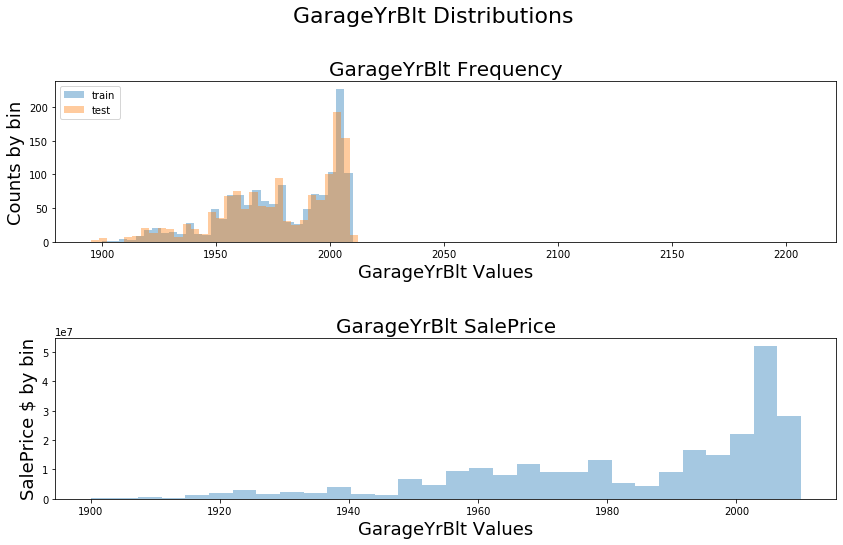

In [179]:
for feature in ['GarageYrBlt']:
    dist_plot(df,feature,df_test = test )

In [73]:
summary_table(df[list(df.columns)[60:]])

dtypes  missing  uniques    min     max     top  1-freq  \
GarageFinish   object       81        3      -       -     Unf     605   
GarageCars      int64        0        5      0       4       2     824   
GarageArea      int64        0      441      0    1418       0      81   
GarageQual     object       81        5      -       -      TA    1311   
GarageCond     object       81        5      -       -      TA    1326   
PavedDrive     object        0        3      -       -       Y    1340   
WoodDeckSF      int64        0      274      0     857       0     761   
OpenPorchSF     int64        0      202      0     547       0     656   
EnclosedPorch   int64        0      120      0     552       0    1252   
3SsnPorch       int64        0       20      0     508       0    1436   
ScreenPorch     int64        0       76      0     480       0    1344   
PoolArea        int64        0        8      0     738       0    1453   
PoolQC         object     1453        3      -       -      Gd       3   
Fence          object     1179        4      -       -   MnPrv     157   
MiscFeature    object     1406        4      -       -    Shed      49   
MiscVal         int64        0       21      0   15500       0    1408   
MoSold          int64        0       12      1      12       6     253   
YrSold          int64        0        5   2006    2010    2009     338   
SaleType       object        0        9      -       -      WD    1267   
SaleCondition  object        0        6      -       -  Normal    1198   
SalePrice       int64        0      663  34900  755000  140000      20   

              2nd most  2-freq 3rd most  3-freq  
GarageFinish       RFn     422      Fin     352  
GarageCars           1     369        3     181  
GarageArea         440      49      576      47  
GarageQual          Fa      48       Gd      14  
GarageCond          Fa      35       Gd       9  
PavedDrive           N      90        P      30  
WoodDeckSF         192      38      100      36  
OpenPorchSF         36      29       48      22  
EnclosedPorch      112      15       96       6  
3SsnPorch          168       3      216       2  
ScreenPorch        192       6      224       5  
PoolArea           738       1      648       1  
PoolQC              Ex       2       Fa       2  
Fence            GdPrv      59     GdWo      54  
MiscFeature       Gar2       2     Othr       2  
MiscVal            400      11      500       8  
MoSold               7     234        5     204  
YrSold            2007     329     2006     314  
SaleType           New     122      COD      43  
SaleCondition  Partial     125  Abnorml     101  
SalePrice       135000      17   145000      14

In [80]:
summary_table(test[list(test.columns)[60:]])

dtypes  missing  uniques   min    max     top 1-freq 2nd most  \
GarageFinish    object       78        3     -      -     Unf    625      RFn   
GarageCars     float64        1        6     0      5       2    770        1   
GarageArea     float64        1      459     0   1488       0     76      576   
GarageQual      object       78        4     -      -      TA   1293       Fa   
GarageCond      object       78        5     -      -      TA   1328       Fa   
PavedDrive      object        0        3     -      -       Y   1301        N   
WoodDeckSF       int64        0      263     0   1424       0    762      100   
OpenPorchSF      int64        0      203     0    742       0    642       48   
EnclosedPorch    int64        0      131     0   1012       0   1208       96   
3SsnPorch        int64        0       13     0    360       0   1446      153   
ScreenPorch      int64        0       75     0    576       0   1319      144   
PoolArea         int64        0        7     0    800       0   1453      800   
PoolQC          object     1456        2     -      -      Ex      2       Gd   
Fence           object     1169        4     -      -   MnPrv    172    GdPrv   
MiscFeature     object     1408        3     -      -    Shed     46     Gar2   
MiscVal          int64        0       26     0  17000       0   1408      400   
MoSold           int64        0       12     1     12       6    250        7   
YrSold           int64        0        5  2006   2010    2007    363     2008   
SaleType        object        1        9     -      -      WD   1258      New   
SaleCondition   object        0        6     -      -  Normal   1204  Partial   

              2-freq 3rd most 3-freq  
GarageFinish     389      Fin    367  
GarageCars       407        3    193  
GarageArea        50      440     47  
GarageQual        76       Gd     10  
GarageCond        39       Po      7  
PavedDrive       126        P     32  
WoodDeckSF        38      192     32  
OpenPorchSF       29       32     27  
EnclosedPorch      7      168      7  
3SsnPorch          2      360      1  
ScreenPorch       10      168      7  
PoolArea           1      561      1  
PoolQC             1        -      -  
Fence             59     GdWo     58  
MiscFeature        3     Othr      2  
MiscVal            7      450      5  
MoSold           212        5    190  
YrSold           318     2009    309  
SaleType         117      COD     44  
SaleCondition    120  Abnorml     89

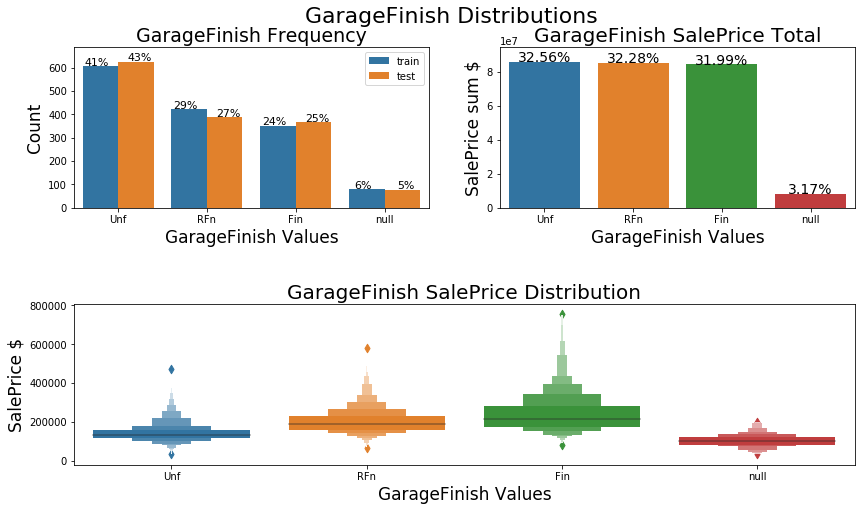

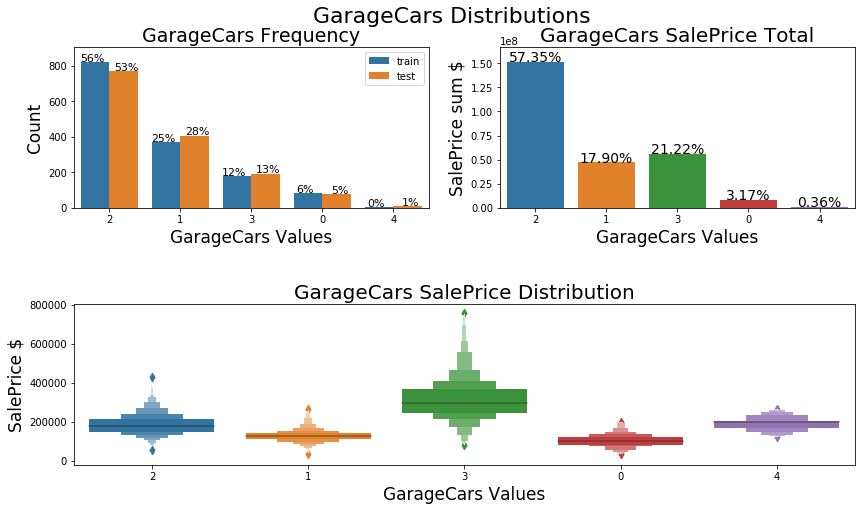

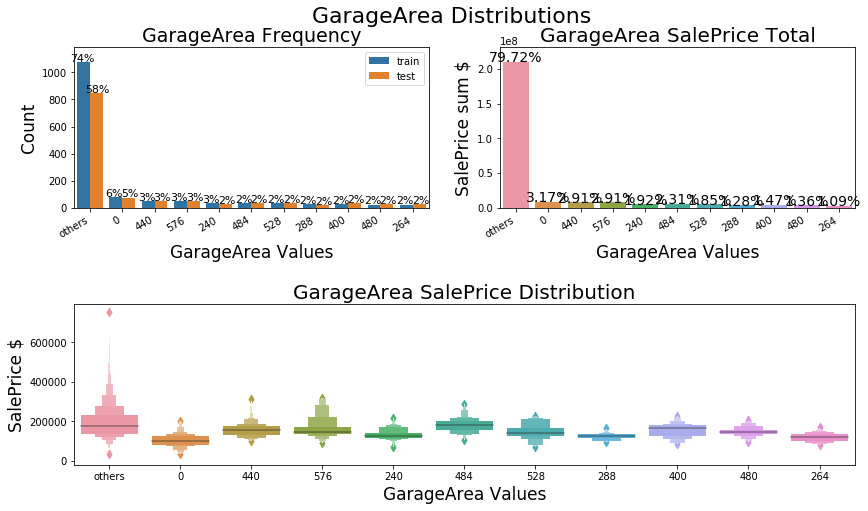

posx and posy should be finite values
posx and posy should be finite values


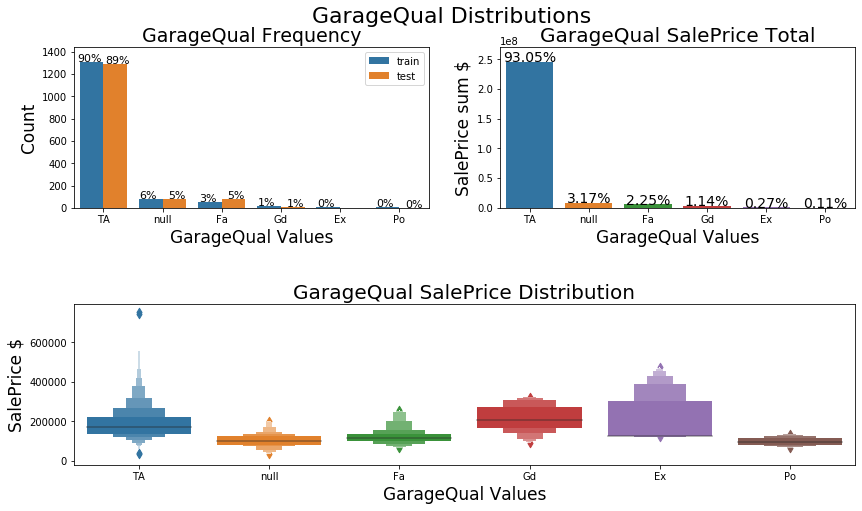

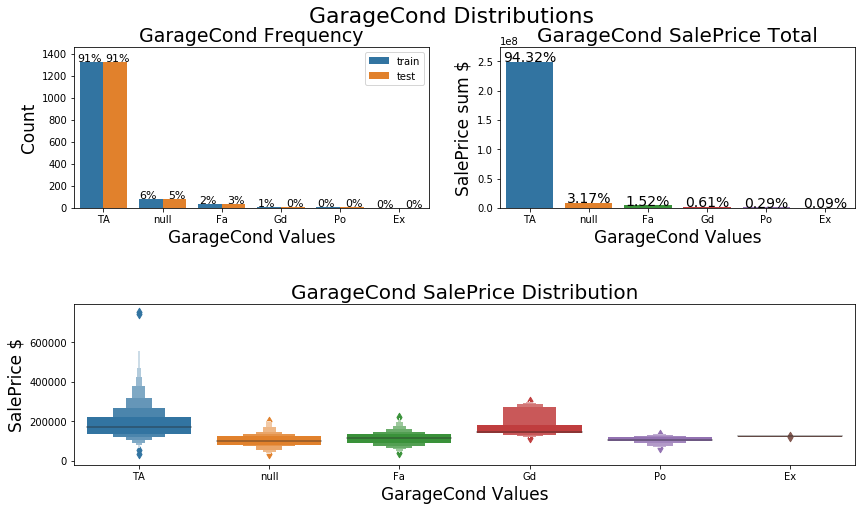

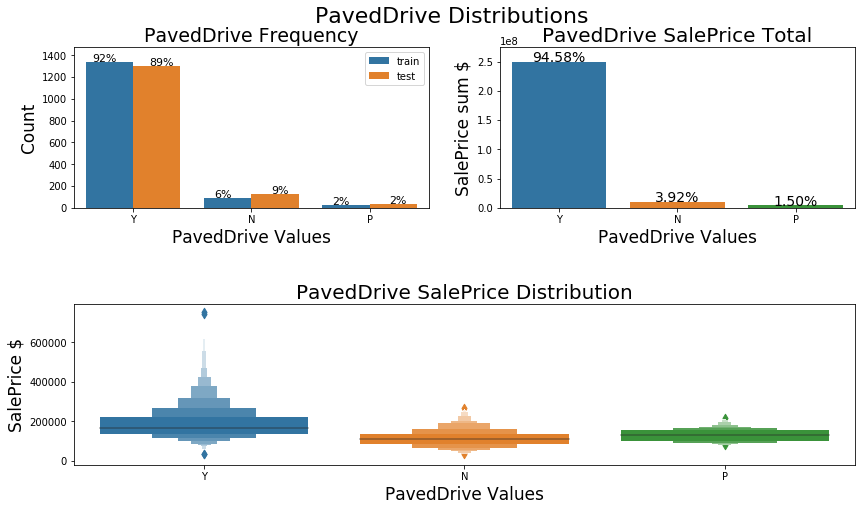

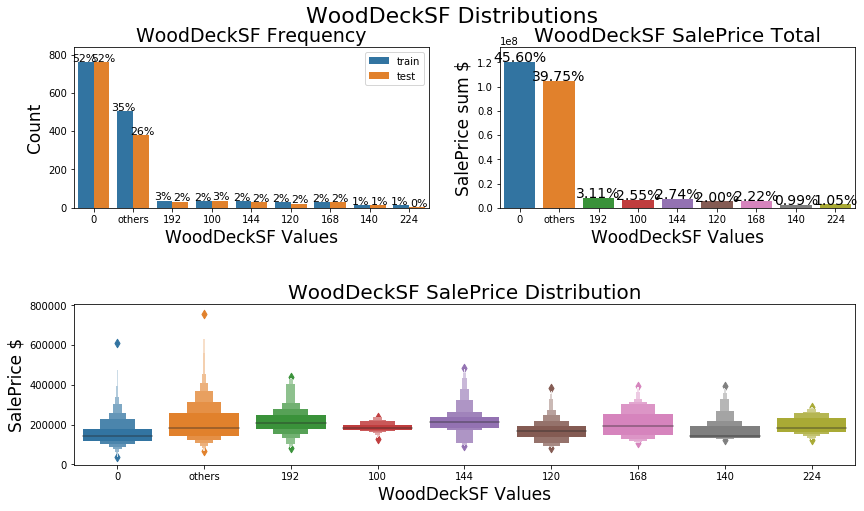

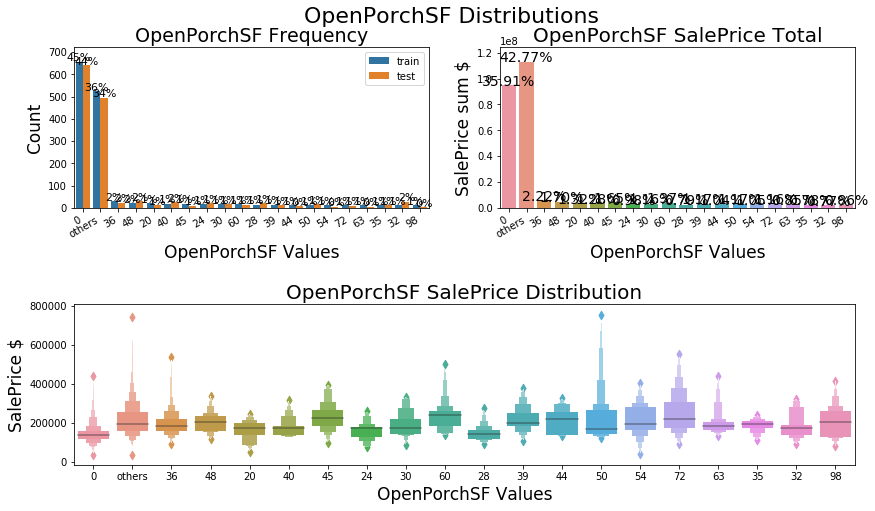

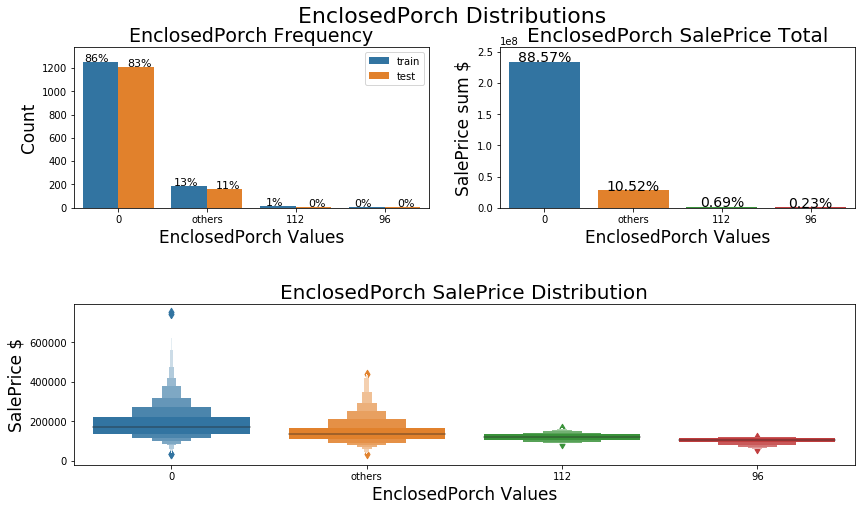

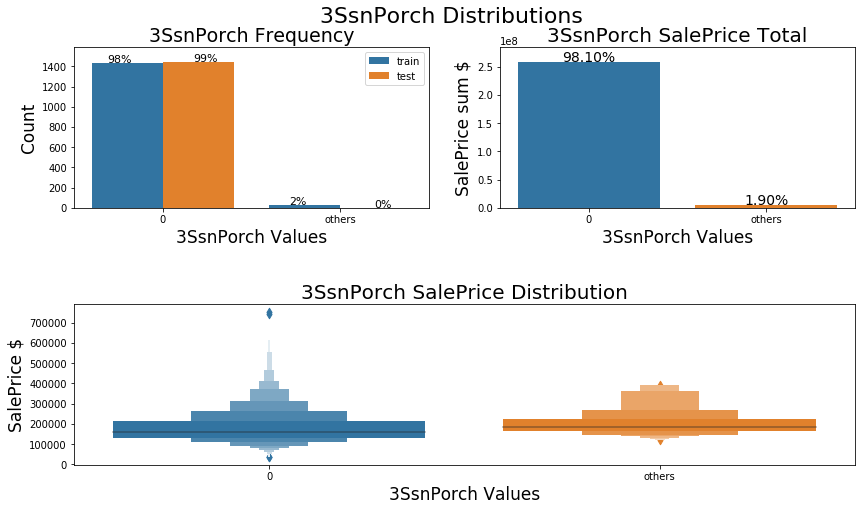

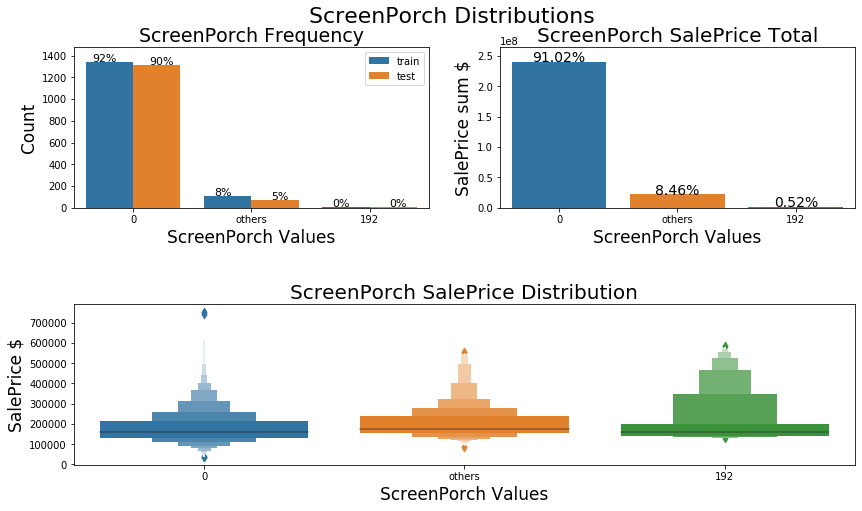

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


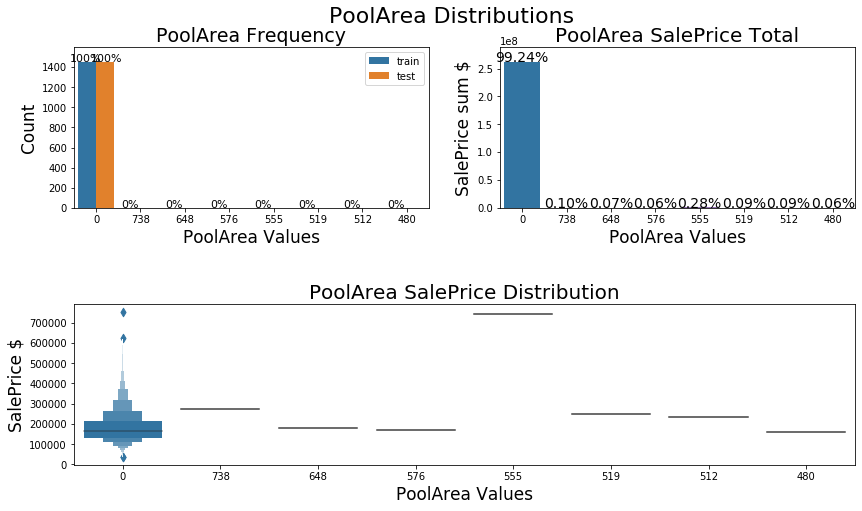

posx and posy should be finite values
posx and posy should be finite values


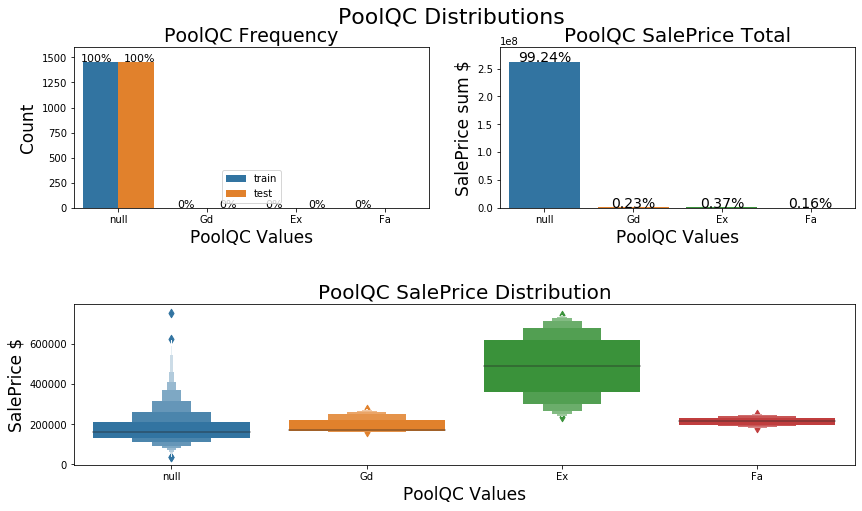

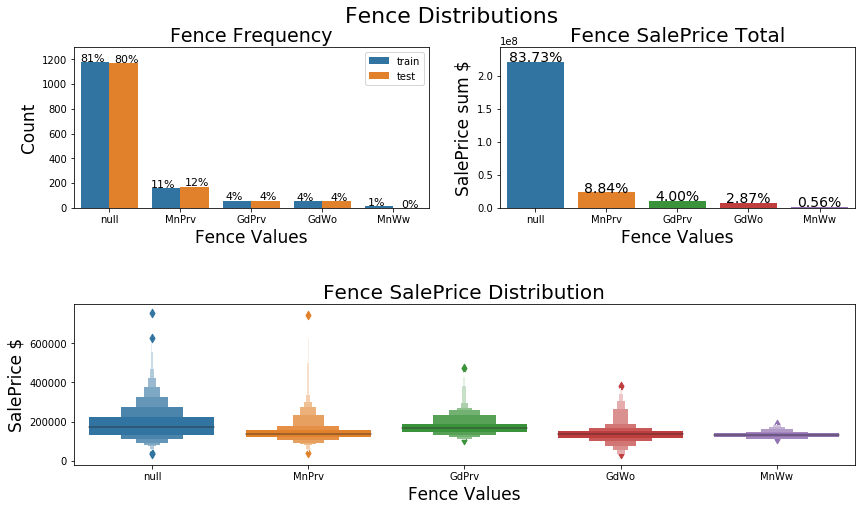

posx and posy should be finite values
posx and posy should be finite values


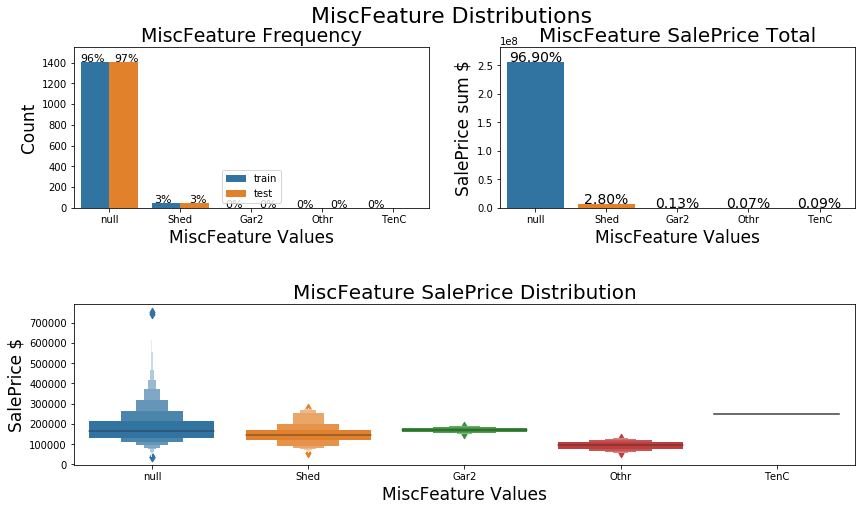

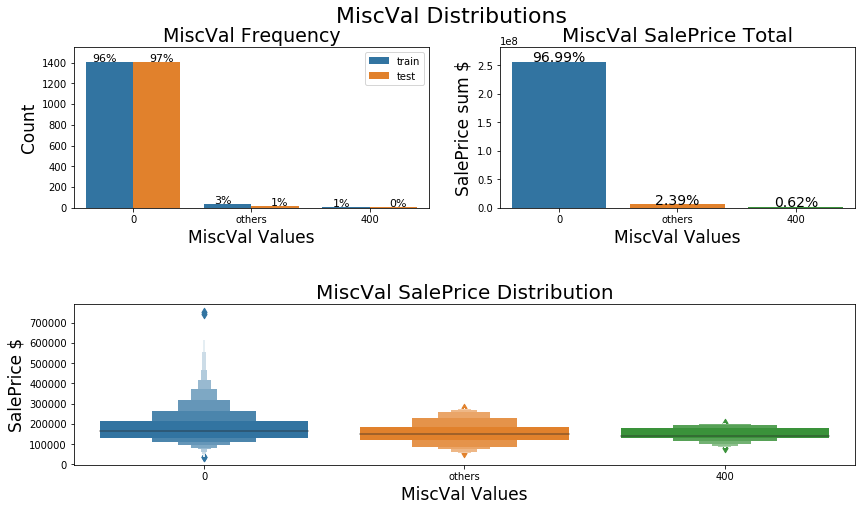

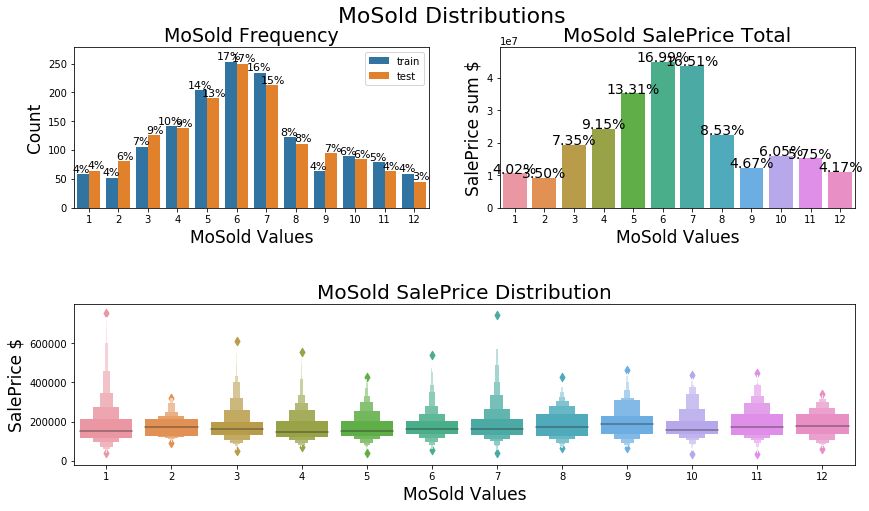

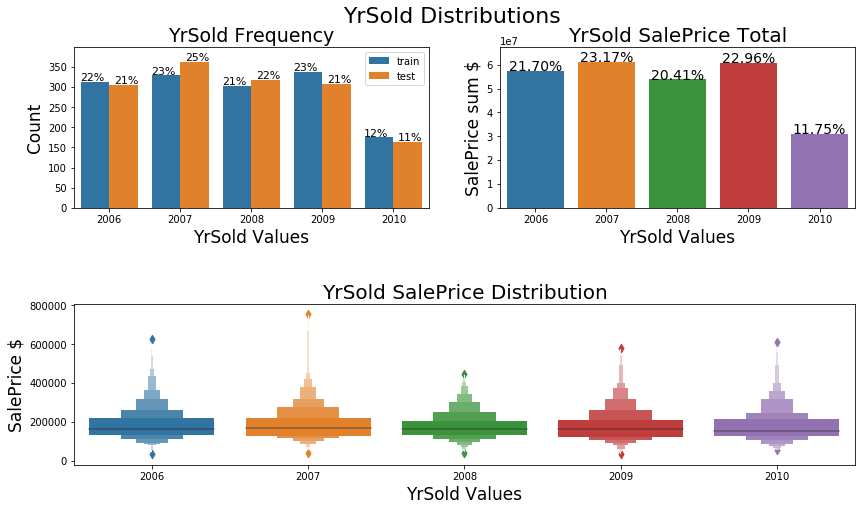

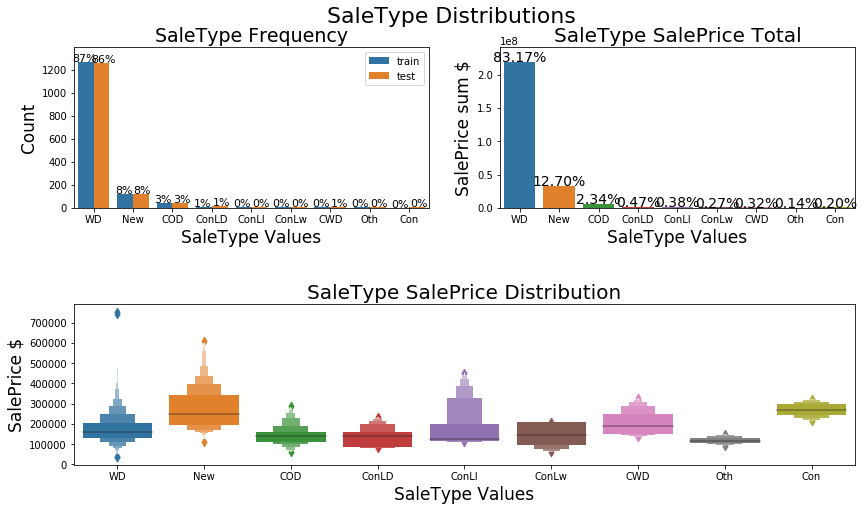

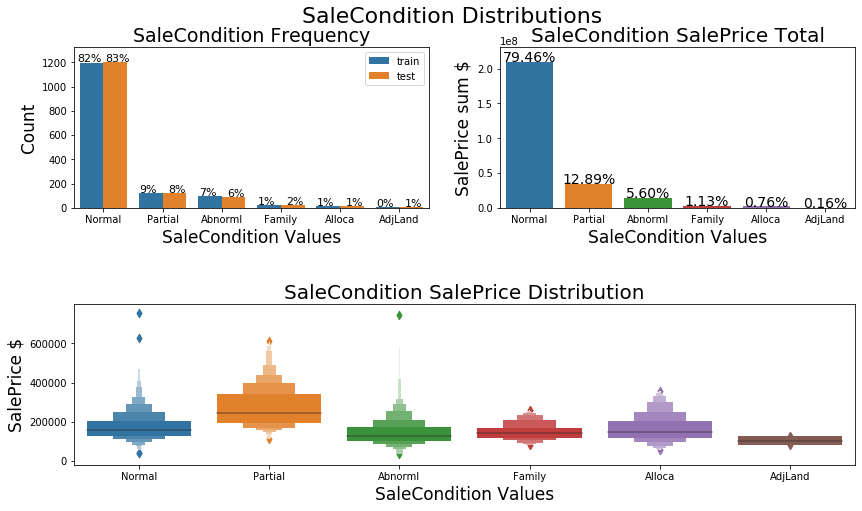

In [189]:
for feature in df.columns[60:]:
    if feature == 'SalePrice':
        continue
    if feature in ['GarageArea']:
        bar_plot(df,feature,others_threshold=20, xtick_rotate=True, df_test = test)
        continue
    if feature in ['OpenPorchSF']:
        bar_plot(df,feature, xtick_rotate=True, df_test = test)
        continue    
    if feature in ['EnclosedPorch','3SsnPorch','ScreenPorch']:
        bar_plot(df,feature,others_threshold=5,  df_test = test)
        continue
    if feature in ['MoSold','YrSold']:
        bar_plot(df,feature,  df_test = test, sorted_plot_order=True)
        continue
    if df[feature].nunique() < 10:
        bar_plot(df,feature,others_threshold=0, df_test =test)
        continue
    bar_plot(df,feature, df_test = test)